In [45]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.optim import Adam
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from tqdm import trange
from copy import deepcopy

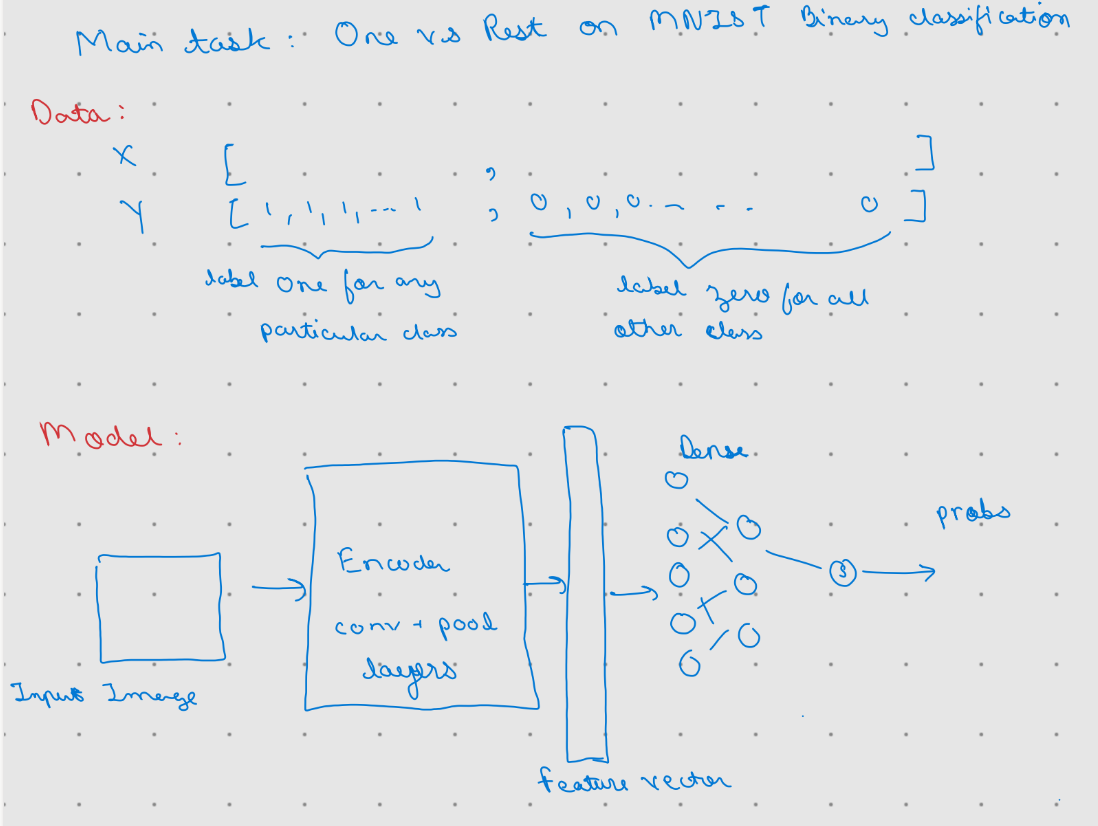
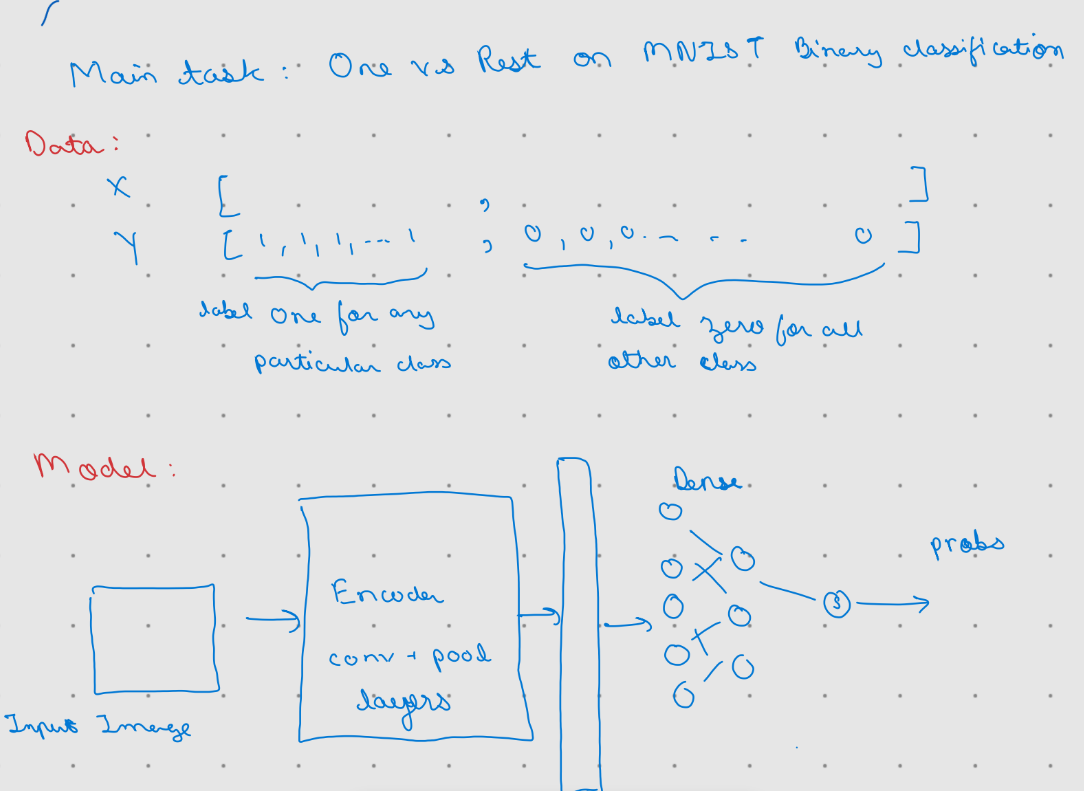

In [2]:
# List all available GPU devices
device_count = torch.cuda.device_count()
print(device_count) 
for i in range(device_count):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


4
GPU 0: NVIDIA A100-SXM4-80GB
GPU 1: NVIDIA A100-SXM4-80GB
GPU 2: NVIDIA A100-SXM4-80GB
GPU 3: NVIDIA A100-SXM4-80GB


In [3]:
# Assign a specific GPU 
device = torch.device("cuda:0")
print("Selected Device:", torch.cuda.get_device_name(device))
print(device) 

Selected Device: NVIDIA A100-SXM4-80GB
cuda:0


In [4]:
train_dataset = MNIST(root='./data', train=True, download=True)
test_dataset = MNIST(root='./data', train=False, download=True)
train_dataset.data.shape, test_dataset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [5]:
target_digit = 0
train_data_target = train_dataset.data[train_dataset.targets == target_digit]
train_data_rest = train_dataset.data[train_dataset.targets != target_digit]
train_data_target.shape, train_data_rest.shape 

(torch.Size([5923, 28, 28]), torch.Size([54077, 28, 28]))

In [6]:
test_data_target = test_dataset.data[test_dataset.targets == target_digit]
test_data_rest = test_dataset.data[test_dataset.targets != target_digit]
test_data_target.shape, test_data_rest.shape 

(torch.Size([980, 28, 28]), torch.Size([9020, 28, 28]))

Concating 

In [7]:
data_train = torch.cat((train_data_target, train_data_rest), dim=0)
label_train = torch.cat((torch.ones(len(train_data_target)), torch.zeros(len(train_data_rest))), dim=0)
data_test = torch.cat((test_data_target, test_data_rest), dim=0)
label_test = torch.cat((torch.ones(len(test_data_target)), torch.zeros(len(test_data_rest))), dim=0)   
data_train.shape, label_train.shape, data_test.shape, label_test.shape 

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [8]:
train_size = 1000
random_indices = torch.randperm(len(data_train))[:train_size]
print(random_indices)
x_train = data_train[random_indices]
y_train = label_train[random_indices]
x_train.shape, y_train.shape 

tensor([24409, 19444, 53414, 57323, 54342, 31315, 39523, 34508, 35162,  9786,
        33564, 21761, 32358, 40150, 46015, 34535, 49478, 47250, 56258, 52410,
         9791, 51743,   635, 24013, 40854,  5632, 59297, 30756, 34704, 13929,
        53621, 45122, 19490, 12703, 40403,  8887, 39762, 40782, 12293, 56462,
        39816,  9967, 13395, 22818,  3915,  6476, 33183,   369,  3143, 24866,
          682, 22383, 25283, 51901, 29572, 25896, 51312, 31625, 15081, 39159,
        40906,  9810, 18799, 36974,  5883,  5047, 41180, 29873,  1842,  1543,
        38147, 45447,  2515, 27197, 30137,  9648,  9803, 47768, 50002, 53849,
        11962, 10641, 54266, 25144, 31793, 29582, 54264, 32973, 52484, 56115,
        12619, 38936, 35762, 19615,  1478,  7799,   840, 43706, 44249, 56737,
         2249, 40528, 33806, 50921, 55134, 56455, 37122, 39123,  9848, 15641,
         6830, 50682, 45674, 41537,  2757, 49255, 17302, 36547, 58225, 18114,
        27506, 29023,   415, 57651, 27298, 45018, 39302, 28775, 

(torch.Size([1000, 28, 28]), torch.Size([1000]))

# CNN

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 4, 3, padding=1)
        self.fc1 = nn.Linear(4 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

    def encoder(self,x):
        # gives features 
        x = x.view(-1, 1, 28, 28)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 4 * 3 * 3)
        return x 

    def forward(self, x, features=False):
        x = self.encoder(x) 
        # applying dense layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))
        return x 

model = CNN().to(device)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [10]:
# trying model  for one image
output_temp = model(x_train[0].to(device).float())
print(output_temp, output_temp.shape)
label_temp = y_train[0].to(device).float().view(-1, 1)
print(label_temp, label_temp.shape)
loss_temp = criterion(output_temp, label_temp)
print(loss_temp)

tensor([[0.7766]], device='cuda:0', grad_fn=<SigmoidBackward0>) torch.Size([1, 1])
tensor([[0.]], device='cuda:0') torch.Size([1, 1])
tensor(1.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


Train function

In [11]:
def train(model, x, y, epochs=10, lr=0.001):
    torch.manual_seed(4)
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    model.train()
    loss_list = []
    # prob_list = []
    for epoch in range(epochs):
        running_loss = 0.0

        for i in range(len(x)):
            inputs = x[i].to(device).float()
            labels = y[i].to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # prob_list.append(outputs.item())
        loss_list.append(running_loss / len(x))
        
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(x)}")

    return loss_list


In [12]:
loss_list = train(model, x_train[:3], y_train[:3], epochs=2, lr=0.001)
print(loss_list)

Epoch 1, Loss: 0.7491189104815325
Epoch 2, Loss: 0.17394842021167278
[0.7491189104815325, 0.17394842021167278]


In [13]:
fea = model.encoder(x_train[0].to(device).float())
fea

tensor([[ 3.2937, 21.4227, 21.2446, 15.9088, 40.9018, 34.5154, 22.2757, 49.6243,
         34.1255,  0.6482, 15.2682, 10.8840, 14.2285, 18.6413,  6.3737, 11.4857,
         15.4124,  1.8437,  0.0000,  0.0000, 11.1187,  0.0000,  0.0000, 11.1060,
          0.0000, 13.3560,  8.2459,  6.2844,  4.2049,  0.0000,  3.5455,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [14]:
def eval(model, x, y):
    model.eval()
    with torch.no_grad():
        probs = model(x.to(device).float())
        probs = probs
        accuracy = ((probs.cpu().squeeze() >= 0.5).float() == y.float()).float().mean().item()
        # print('Accuracy: ',accuracy)
        loss = criterion(probs, y.to(device).float().view(-1, 1))
        return probs.cpu().squeeze().numpy(), accuracy, loss.item()

In [15]:
eval(model, x_train[:3], y_train[:3])

(array([0.00356952, 0.00443206, 0.00235384], dtype=float32),
 1.0,
 0.0034581441432237625)

In [16]:
model = CNN().to(device)
loss_list = train(model, x_train, y_train, epochs=10, lr=0.001)
# print(loss_list)

Epoch 1, Loss: 0.29904945256858273
Epoch 2, Loss: 0.15370363211750596
Epoch 3, Loss: 0.10971911235016227
Epoch 4, Loss: 0.10687324555416759
Epoch 5, Loss: 0.08483178514271587
Epoch 6, Loss: 0.060076619047090926
Epoch 7, Loss: 0.05504837340098745
Epoch 8, Loss: 0.06596281981163546
Epoch 9, Loss: 0.05674550059442102
Epoch 10, Loss: 0.037649730024360985


In [17]:
probs, accuracy, loss = eval(model, data_test, label_test)
print('Accuracy: ',accuracy)
print('Loss: ',loss) 

Accuracy:  0.9860000014305115
Loss:  0.08237055689096451


# AL

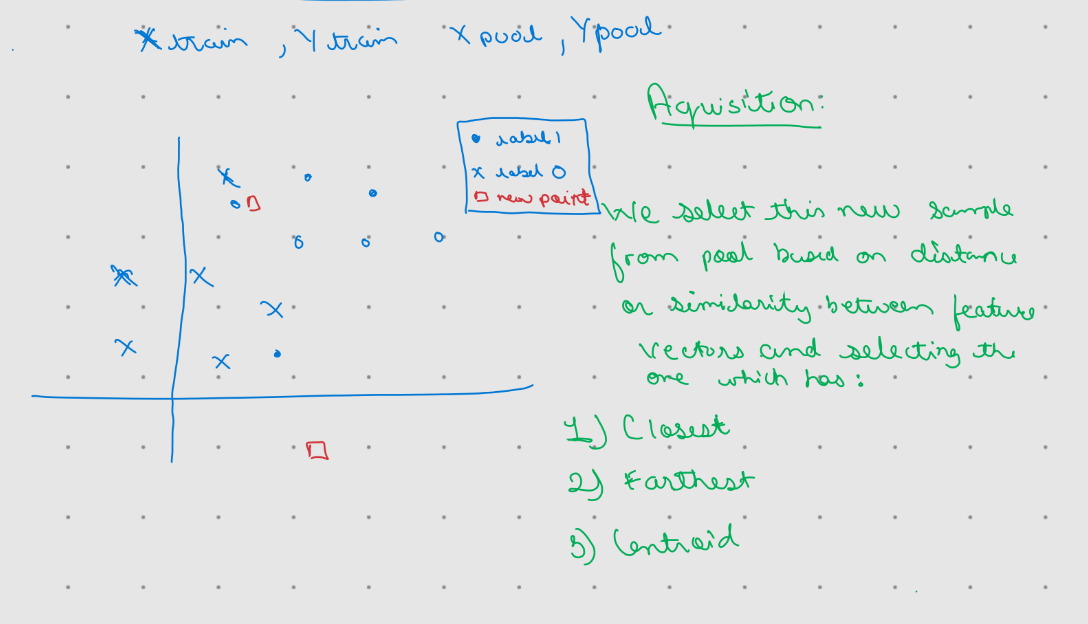

In [18]:
train_size = 2 # selecting 2 samples from each class ie 0 or 1
random_indices_target = torch.randperm(len(train_data_target))[:train_size]
selected_data_target = train_data_target[random_indices_target]
selected_label_target = torch.ones(len(selected_data_target))

random_indices_rest = torch.randperm(len(train_data_rest))[:train_size]
selected_data_rest = train_data_rest[random_indices_rest]
selected_label_rest = torch.zeros(len(selected_data_rest))

x_train = torch.cat((selected_data_target, selected_data_rest), dim=0)
y_train = torch.cat((selected_label_target, selected_label_rest), dim=0)

seed = 42
torch.manual_seed(seed)
random_indices = torch.randperm(x_train.shape[0])
x_train = x_train[random_indices] # shuffle
y_train = y_train[random_indices] # shuffle
x_train.shape, y_train.shape, y_train

(torch.Size([4, 28, 28]), torch.Size([4]), tensor([0., 0., 1., 1.]))

In [19]:
indices_remaining_target = torch.tensor([i for i in range(train_data_target.size(0)) if i not in random_indices_target])
indices_remaining_rest = torch.tensor([i for i in range(train_data_rest.size(0)) if i not in random_indices_rest])

x_pool = torch.cat((train_data_target[indices_remaining_target], train_data_rest[indices_remaining_rest]), dim=0)
y_pool = torch.cat((torch.ones(len(indices_remaining_target)), torch.zeros(len(indices_remaining_rest))), dim=0)
torch.manual_seed(seed)
random_indices = torch.randperm(x_pool.shape[0]) 
x_pool = x_pool[random_indices] # shuffle
y_pool = y_pool[random_indices] # shuffle
x_pool.shape, y_pool.shape

(torch.Size([59996, 28, 28]), torch.Size([59996]))

In [20]:
def centroid(model, t_x, p_x, p_y):
    features = model.encoder(t_x.to(device).float())
    centroid_feature = torch.mean(features, dim=0)
    pool_features = model.encoder(p_x.to(device).float())
    distance = torch.cdist(pool_features, centroid_feature.reshape(1, -1))
    n_max_idx = torch.argmax(distance)

    return n_max_idx, p_x[n_max_idx], p_y[n_max_idx]

def farthest(model, t_x, p_x, p_y):
    features = model.encoder(t_x.to(device).float())
    pool_features = model.encoder(p_x.to(device).float())
    distances = torch.cdist(pool_features, features)
    farthest = torch.max(distances, dim=1)
    n_max_idx = torch.argmax(farthest.values)

    return n_max_idx, p_x[n_max_idx], p_y[n_max_idx]

def closest(model, t_x, p_x, p_y):
    features = model.encoder(t_x.to(device).float())
    pool_features = model.encoder(p_x.to(device).float())
    distances = torch.cdist(pool_features, features)
    closest = torch.min(distances, dim=1)
    n_max_idx = torch.argmin(closest.values)

    return n_max_idx, p_x[n_max_idx], p_y[n_max_idx]
    

AL loop

In [90]:
acquisions_function_dict = {0: centroid, 1: farthest, 2: closest}
epochs = 20
accuracy_list = [[],[],[]]
loss_list = [[],[],[]]
for i in acquisions_function_dict.keys():
    print(f"-----------------------Running for {acquisions_function_dict[i]}-----------------------")
    acquisions_function = acquisions_function_dict[i]
    model = CNN().to(device) 
    t_x = deepcopy(x_train)
    t_y = deepcopy(y_train)
    p_x = deepcopy(x_pool)
    p_y = deepcopy(y_pool)

    for j in trange(epochs):
        loss_train = train(model, t_x, t_y, epochs=15)
        probs, accuracy, loss = eval(model, p_x, p_y)
        accuracy_list[i].append(accuracy)
        loss_list[i].append(loss)

        ind, x ,y = acquisions_function(model, t_x, p_x, p_y)
        t_x = torch.cat((t_x, x.reshape(-1,28,28)), dim=0)
        t_y = torch.cat((t_y, y.reshape(-1)), dim=0)

        # excluding the selected sample from pool
        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)


-----------------------Running for <function centroid at 0x7fe560adcc10>-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:12,  1.47it/s]

Epoch 1, Loss: 0.27367729097604754
Epoch 2, Loss: 0.16963070202618838
Epoch 3, Loss: 0.4221583541482687
Epoch 4, Loss: 0.043000895506702365
Epoch 5, Loss: 0.05038314580451697
Epoch 6, Loss: 0.8667913129553199
Epoch 7, Loss: 0.11147606649901717
Epoch 8, Loss: 0.23138392791152002
Epoch 9, Loss: 0.21854535413440318
Epoch 10, Loss: 0.06557774320244789
Epoch 11, Loss: 0.4777312852442265
Epoch 12, Loss: 0.05962292477488518
Epoch 13, Loss: 0.024232724448665977
Epoch 14, Loss: 0.026186269475147128
Epoch 15, Loss: 0.3892653306014836


 10%|█         | 2/20 [00:01<00:12,  1.46it/s]

Epoch 1, Loss: 0.27698777699148946
Epoch 2, Loss: 0.003609664925510477
Epoch 3, Loss: 0.032453379933443216
Epoch 4, Loss: 9.884091637276289e-05
Epoch 5, Loss: 0.03598384323100845
Epoch 6, Loss: 7.965444466625134e-05
Epoch 7, Loss: 0.041483039318180204
Epoch 8, Loss: 0.002331429811118557
Epoch 9, Loss: 0.00071625365668145
Epoch 10, Loss: 0.0008463097701986536
Epoch 11, Loss: 0.0002583088112591003
Epoch 12, Loss: 0.0007676743252602591
Epoch 13, Loss: 2.9827789936390237e-06
Epoch 14, Loss: 0.008390942288280299
Epoch 15, Loss: 7.80265401464283e-06


 15%|█▌        | 3/20 [00:02<00:12,  1.34it/s]

Epoch 1, Loss: 0.5208275241086604
Epoch 2, Loss: 0.056188267363717494
Epoch 3, Loss: 5.24221684296476e-06
Epoch 4, Loss: 1.5593948759719953
Epoch 5, Loss: 7.00786292128933e-06
Epoch 6, Loss: 0.0002862248554016218
Epoch 7, Loss: 0.00015691638955433998
Epoch 8, Loss: 0.008284783815657965
Epoch 9, Loss: 0.1168744449108803
Epoch 10, Loss: 0.004207591381569279
Epoch 11, Loss: 0.9371521391572545
Epoch 12, Loss: 0.029744227975112687
Epoch 13, Loss: 0.00017196033409153495
Epoch 14, Loss: 0.011231964009035826
Epoch 15, Loss: 0.005440665455396156


 20%|██        | 4/20 [00:03<00:12,  1.29it/s]

Epoch 1, Loss: 0.00010601200453433958
Epoch 2, Loss: 5.888837091462496e-05
Epoch 3, Loss: 1.0765760778263123e-06
Epoch 4, Loss: 2.4547647106342426e-05
Epoch 5, Loss: 2.3881976838773057e-08
Epoch 6, Loss: 0.0001592914195582052
Epoch 7, Loss: 0.14383448396279355
Epoch 8, Loss: 4.4869009340110456e-07
Epoch 9, Loss: 7.814393448052923e-07
Epoch 10, Loss: 5.4871630219785365e-05
Epoch 11, Loss: 2.480610291799212e-10
Epoch 12, Loss: 0.047904716102943
Epoch 13, Loss: 0.8631436270072277
Epoch 14, Loss: 0.0002350919467062612
Epoch 15, Loss: 5.235476956638762e-05


 25%|██▌       | 5/20 [00:04<00:13,  1.14it/s]

Epoch 1, Loss: 4.4071994842041475e-09
Epoch 2, Loss: 2.6491141414338492e-08
Epoch 3, Loss: 7.386984192046684e-14
Epoch 4, Loss: 1.3245581654786247e-08
Epoch 5, Loss: 3.568691384971107e-05
Epoch 6, Loss: 4.399513677369248e-06
Epoch 7, Loss: 2.470024128434803
Epoch 8, Loss: 0.00347540362642293
Epoch 9, Loss: 3.4085466396283733e-13
Epoch 10, Loss: 0.00039452736058996786
Epoch 11, Loss: 1.9138056461055244e-09
Epoch 12, Loss: 1.27924606099283e-10
Epoch 13, Loss: 2.5446116552580318e-05
Epoch 14, Loss: 0.20198525329448172
Epoch 15, Loss: 1.1164838927865587e-05


 30%|███       | 6/20 [00:05<00:13,  1.05it/s]

Epoch 1, Loss: 2.7868478658562477e-10
Epoch 2, Loss: 0.0005071725335525168
Epoch 3, Loss: 5.3730482663146694e-08
Epoch 4, Loss: 6.893898114117981e-11
Epoch 5, Loss: 1.702157812853702e-07
Epoch 6, Loss: 0.0004593838309165225
Epoch 7, Loss: 1.0333244706431567e-07
Epoch 8, Loss: 5.6583512127194746e-18
Epoch 9, Loss: 4.943850165419166e-19
Epoch 10, Loss: 4.91262947894714e-05
Epoch 11, Loss: 2.928512557466121e-16
Epoch 12, Loss: 1.3046213247125821e-15
Epoch 13, Loss: 0.00046801711432635783
Epoch 14, Loss: 5.7517845153808596
Epoch 15, Loss: 0.0011434040032497705


 35%|███▌      | 7/20 [00:06<00:12,  1.00it/s]

Epoch 1, Loss: 0.3658963550220836
Epoch 2, Loss: 5.362098700661622e-24
Epoch 3, Loss: 9.090909090909092
Epoch 4, Loss: 6.140019384674029e-16
Epoch 5, Loss: 3.24639600926141e-20
Epoch 6, Loss: 9.091158180529355
Epoch 7, Loss: 6.465439263831203e-21
Epoch 8, Loss: 0.9102542183615955
Epoch 9, Loss: 2.059071820522976e-07
Epoch 10, Loss: 0.6191011775623668
Epoch 11, Loss: 4.333605948539079e-24
Epoch 12, Loss: 0.0051614824269718565
Epoch 13, Loss: 4.224738135085541e-10
Epoch 14, Loss: 10.267877578735352
Epoch 15, Loss: 2.414083094444985e-21


 40%|████      | 8/20 [00:07<00:11,  1.03it/s]

Epoch 1, Loss: 2.4888072029027046e-21
Epoch 2, Loss: 9.678534069790847e-13
Epoch 3, Loss: 0.015190270086721691
Epoch 4, Loss: 4.812566639870159e-16
Epoch 5, Loss: 1.0210878069053902e-08
Epoch 6, Loss: 1.1354136176917518e-21
Epoch 7, Loss: 8.333333333333334
Epoch 8, Loss: 6.73556254090129e-05
Epoch 9, Loss: 8.89466839958766e-21
Epoch 10, Loss: 2.8417377964726062e-21
Epoch 11, Loss: 2.299457993802425e-17
Epoch 12, Loss: 2.5648042759368604e-24
Epoch 13, Loss: 0.20146671930948892
Epoch 14, Loss: 2.9221332321564358e-05
Epoch 15, Loss: 2.367168585459391


 45%|████▌     | 9/20 [00:08<00:10,  1.04it/s]

Epoch 1, Loss: 2.3077257062937923e-21
Epoch 2, Loss: 0.7096761648471551
Epoch 3, Loss: 2.5738653041463343e-20
Epoch 4, Loss: 3.790947247637678e-22
Epoch 5, Loss: 1.5985477325600213e-06
Epoch 6, Loss: 0.3119709212332964
Epoch 7, Loss: 2.848484022892714e-10
Epoch 8, Loss: 5.486812237536383e-06
Epoch 9, Loss: 1.2824090744248625e-12
Epoch 10, Loss: 0.07749433746300624
Epoch 11, Loss: 0.5472054848304162
Epoch 12, Loss: 5.025790633576084e-07
Epoch 13, Loss: 0.03974897127885194
Epoch 14, Loss: 0.6567105789203814
Epoch 15, Loss: 0.024217543693689277


 50%|█████     | 10/20 [00:09<00:10,  1.05s/it]

Epoch 1, Loss: 2.3730899556539953e-05
Epoch 2, Loss: 0.0633661256371332
Epoch 3, Loss: 1.0942927580153099e-08
Epoch 4, Loss: 5.015482547556572e-06
Epoch 5, Loss: 5.345874146592271e-11
Epoch 6, Loss: 7.632550597025138e-09
Epoch 7, Loss: 3.5339019842972304e-25
Epoch 8, Loss: 2.1271046895920477e-22
Epoch 9, Loss: 2.2804148410983593e-08
Epoch 10, Loss: 4.223048295228776e-15
Epoch 11, Loss: 2.7623578459790715e-05
Epoch 12, Loss: 0.20157827650178675
Epoch 13, Loss: 1.558252733957488e-06
Epoch 14, Loss: 2.765068467026649
Epoch 15, Loss: 1.7638359860491736e-08


 55%|█████▌    | 11/20 [00:10<00:10,  1.15s/it]

Epoch 1, Loss: 0.3327473656946575
Epoch 2, Loss: 0.0012389880600494508
Epoch 3, Loss: 8.490237312924829e-21
Epoch 4, Loss: 9.996469362177013e-22
Epoch 5, Loss: 1.6722324947379902e-12
Epoch 6, Loss: 9.069220500136454e-17
Epoch 7, Loss: 6.666666666666667
Epoch 8, Loss: 8.839498835655735e-35
Epoch 9, Loss: 4.8605561830397453e-17
Epoch 10, Loss: 2.495495796168465e-06
Epoch 11, Loss: 1.4164802294930713e-09
Epoch 12, Loss: 0.8431032180786133
Epoch 13, Loss: 1.3359697471883294e-14
Epoch 14, Loss: 1.413595354806266e-25
Epoch 15, Loss: 0.051790288913374144


 60%|██████    | 12/20 [00:11<00:09,  1.15s/it]

Epoch 1, Loss: 1.0164489692644724e-12
Epoch 2, Loss: 7.35326072772036e-15
Epoch 3, Loss: 2.556155536811257e-12
Epoch 4, Loss: 2.018777594778907e-09
Epoch 5, Loss: 3.5284731127813575e-05
Epoch 6, Loss: 7.5467546573506e-32
Epoch 7, Loss: 0.626309067612965
Epoch 8, Loss: 5.879014767689048e-12
Epoch 9, Loss: 3.7949020537109135e-08
Epoch 10, Loss: 0.10178992491408145
Epoch 11, Loss: 1.5072738975340485
Epoch 12, Loss: 8.468107939107431e-07
Epoch 13, Loss: 2.249098335555472e-08
Epoch 14, Loss: 9.615658200434751e-05
Epoch 15, Loss: 7.572430907210048e-06


 65%|██████▌   | 13/20 [00:12<00:07,  1.11s/it]

Epoch 1, Loss: 7.1549043030175014e-09
Epoch 2, Loss: 8.414779424939887e-08
Epoch 3, Loss: 0.022687424634879737
Epoch 4, Loss: 2.1858465983326734e-17
Epoch 5, Loss: 1.542710459248423e-07
Epoch 6, Loss: 5.707858143977881e-29
Epoch 7, Loss: 1.5568875875570338e-22
Epoch 8, Loss: 9.340957350743696e-20
Epoch 9, Loss: 2.7901983220361446e-06
Epoch 10, Loss: 1.8207840987219357e-31
Epoch 11, Loss: 7.027055635451808e-24
Epoch 12, Loss: 4.295009015336291e-18
Epoch 13, Loss: 0.0
Epoch 14, Loss: 2.4772110216568725e-27
Epoch 15, Loss: 0.0


 70%|███████   | 14/20 [00:14<00:06,  1.11s/it]

Epoch 1, Loss: 6.903588747395539e-40
Epoch 2, Loss: 4.061184354770683e-39
Epoch 3, Loss: 1.585487899216366e-33
Epoch 4, Loss: 1.2400271554066056e-15
Epoch 5, Loss: 6.892237070417936e-13
Epoch 6, Loss: 3.311370101789631e-08
Epoch 7, Loss: 1.827823743673254e-15
Epoch 8, Loss: 8.113018323585322e-21
Epoch 9, Loss: 1.7657560598868824e-10
Epoch 10, Loss: 3.458291003116972e-21
Epoch 11, Loss: 6.270207576300826e-19
Epoch 12, Loss: 1.4659214288713504e-15
Epoch 13, Loss: 7.063294794857424e-23
Epoch 14, Loss: 3.0266879280649306e-11
Epoch 15, Loss: 9.48031218212333e-12


 75%|███████▌  | 15/20 [00:15<00:05,  1.13s/it]

Epoch 1, Loss: 1.9881114056216252e-19
Epoch 2, Loss: 6.2369090851874565e-18
Epoch 3, Loss: 4.110158193798638e-28
Epoch 4, Loss: 2.5096698520524354e-08
Epoch 5, Loss: 0.0040065571665763855
Epoch 6, Loss: 9.575580151030113e-26
Epoch 7, Loss: 1.3654534307331966e-20
Epoch 8, Loss: 1.219074037623657e-11
Epoch 9, Loss: 2.17709662430193e-25
Epoch 10, Loss: 2.0761943026528347e-24
Epoch 11, Loss: 0.0
Epoch 12, Loss: 0.00018208052374814687
Epoch 13, Loss: 1.4767831653403438e-30
Epoch 14, Loss: 5.463247285473137e-05
Epoch 15, Loss: 1.0105868828939268


 80%|████████  | 16/20 [00:16<00:04,  1.11s/it]

Epoch 1, Loss: 0.0006241945084184408
Epoch 2, Loss: 0.0
Epoch 3, Loss: 6.31395365095642e-24
Epoch 4, Loss: 1.0027759692600131e-23
Epoch 5, Loss: 0.002535734139382839
Epoch 6, Loss: 6.587103022582478e-29
Epoch 7, Loss: 1.3722430523878342e-32
Epoch 8, Loss: 9.011191885604299e-20
Epoch 9, Loss: 0.31697649955749513
Epoch 10, Loss: 1.4109944631838258e-37
Epoch 11, Loss: 5.9604651880817984e-09
Epoch 12, Loss: 0.0
Epoch 13, Loss: 1.0480233604439664e-20
Epoch 14, Loss: 3.7733514844851227e-38
Epoch 15, Loss: 4.668324851449345e-24


 85%|████████▌ | 17/20 [00:17<00:03,  1.11s/it]

Epoch 1, Loss: 5.967649600554952e-22
Epoch 2, Loss: 1.5084241363988587e-25
Epoch 3, Loss: 0.0
Epoch 4, Loss: 4.0809923231749103e-13
Epoch 5, Loss: 0.0
Epoch 6, Loss: 2.5605256987041872e-27
Epoch 7, Loss: 1.0220896970861646e-38
Epoch 8, Loss: 1.153462821621943e-21
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 11, Loss: 3.0321970801516495e-35
Epoch 12, Loss: 0.0
Epoch 13, Loss: 5.601949522409551e-34
Epoch 14, Loss: 3.3057099150504745e-27
Epoch 15, Loss: 5.6344513506638155e-30


 90%|█████████ | 18/20 [00:18<00:02,  1.17s/it]

Epoch 1, Loss: 4.659842743612142e-22
Epoch 2, Loss: 0.0
Epoch 3, Loss: 2.2689805733583283e-31
Epoch 4, Loss: 2.521255970289522e-30
Epoch 5, Loss: 0.025489230047572742
Epoch 6, Loss: 6.959092419133909e-19
Epoch 7, Loss: 1.2812387756804872e-05
Epoch 8, Loss: 2.240851406763423e-40
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.0
Epoch 12, Loss: 0.011779628016731956
Epoch 13, Loss: 6.236222986654198e-30
Epoch 14, Loss: 0.0008031445640054616
Epoch 15, Loss: 5.5746924305801575e-39


 95%|█████████▌| 19/20 [00:19<00:01,  1.18s/it]

Epoch 1, Loss: 1.0866376721971352e-22
Epoch 2, Loss: 3.2288540048186014e-14
Epoch 3, Loss: 7.965589032641997e-18
Epoch 4, Loss: 5.1830132070276504e-09
Epoch 5, Loss: 2.082301374451084e-17
Epoch 6, Loss: 1.1132416717250865e-27
Epoch 7, Loss: 5.108118502915759e-18
Epoch 8, Loss: 2.3654667596665826e-11
Epoch 9, Loss: 2.182960313915341e-37
Epoch 10, Loss: 6.742292147532401e-33
Epoch 11, Loss: 0.03489285707473755
Epoch 12, Loss: 2.308867608561464e-05
Epoch 13, Loss: 0.31563167986662494
Epoch 14, Loss: 3.6943624536738983e-31
Epoch 15, Loss: 4.347826086956522


100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


-----------------------Running for <function farthest at 0x7fe560adcb80>-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:08,  2.12it/s]

Epoch 1, Loss: 0.27367729097604754
Epoch 2, Loss: 0.16963070202618838
Epoch 3, Loss: 0.4221583541482687
Epoch 4, Loss: 0.043000895506702365
Epoch 5, Loss: 0.05038314580451697
Epoch 6, Loss: 0.8667913129553199
Epoch 7, Loss: 0.11147606649901717
Epoch 8, Loss: 0.23138392791152002
Epoch 9, Loss: 0.21854535413440318
Epoch 10, Loss: 0.06557774320244789
Epoch 11, Loss: 0.4777312852442265
Epoch 12, Loss: 0.05962292477488518
Epoch 13, Loss: 0.024232724448665977
Epoch 14, Loss: 0.026186269475147128
Epoch 15, Loss: 0.3892653306014836


 10%|█         | 2/20 [00:01<00:09,  1.94it/s]

Epoch 1, Loss: 0.27698777699148946
Epoch 2, Loss: 0.003609664925510477
Epoch 3, Loss: 0.032453379933443216
Epoch 4, Loss: 9.884091637276289e-05
Epoch 5, Loss: 0.03598384323100845
Epoch 6, Loss: 7.965444466625134e-05
Epoch 7, Loss: 0.041483039318180204
Epoch 8, Loss: 0.002331429811118557
Epoch 9, Loss: 0.00071625365668145
Epoch 10, Loss: 0.0008463097701986536
Epoch 11, Loss: 0.0002583088112591003
Epoch 12, Loss: 0.0007676743252602591
Epoch 13, Loss: 2.9827789936390237e-06
Epoch 14, Loss: 0.008390942288280299
Epoch 15, Loss: 7.80265401464283e-06


 15%|█▌        | 3/20 [00:01<00:08,  1.92it/s]

Epoch 1, Loss: 0.5208275241086604
Epoch 2, Loss: 0.056188267363717494
Epoch 3, Loss: 5.24221684296476e-06
Epoch 4, Loss: 1.5593948759719953
Epoch 5, Loss: 7.00786292128933e-06
Epoch 6, Loss: 0.0002862248554016218
Epoch 7, Loss: 0.00015691638955433998
Epoch 8, Loss: 0.008284783815657965
Epoch 9, Loss: 0.1168744449108803
Epoch 10, Loss: 0.004207591381569279
Epoch 11, Loss: 0.9371521391572545
Epoch 12, Loss: 0.029744227975112687
Epoch 13, Loss: 0.00017196033409153495
Epoch 14, Loss: 0.011231964009035826
Epoch 15, Loss: 0.005440665455396156


 20%|██        | 4/20 [00:02<00:08,  1.81it/s]

Epoch 1, Loss: 0.00010601200453433958
Epoch 2, Loss: 5.888837091462496e-05
Epoch 3, Loss: 1.0765760778263123e-06
Epoch 4, Loss: 2.4547647106342426e-05
Epoch 5, Loss: 2.3881976838773057e-08
Epoch 6, Loss: 0.0001592914195582052
Epoch 7, Loss: 0.14383448396279355
Epoch 8, Loss: 4.4869009340110456e-07
Epoch 9, Loss: 7.814393448052923e-07
Epoch 10, Loss: 5.4871630219785365e-05
Epoch 11, Loss: 2.480610291799212e-10
Epoch 12, Loss: 0.047904716102943
Epoch 13, Loss: 0.8631436270072277
Epoch 14, Loss: 0.0002350919467062612
Epoch 15, Loss: 5.235476956638762e-05


 25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch 1, Loss: 1.765263984723371e-08
Epoch 2, Loss: 1.9057570890761527e-13
Epoch 3, Loss: 1.3114577000238783e-13
Epoch 4, Loss: 6.622740479187805e-08
Epoch 5, Loss: 7.573117392848605e-10
Epoch 6, Loss: 0.8056055125364865
Epoch 7, Loss: 0.16102243794466906
Epoch 8, Loss: 0.21333841796183683
Epoch 9, Loss: 1.3249729115692942e-08
Epoch 10, Loss: 5.795208937821414e-12
Epoch 11, Loss: 6.333469521612591e-07
Epoch 12, Loss: 1.212133610342431e-05
Epoch 13, Loss: 2.2583525983894196e-05
Epoch 14, Loss: 0.4341413194651472
Epoch 15, Loss: 0.0632304188724556


 30%|███       | 6/20 [00:03<00:07,  1.87it/s]

Epoch 1, Loss: 0.6694744255079348
Epoch 2, Loss: 1.8119975720780347e-06
Epoch 3, Loss: 7.310808507792355e-22
Epoch 4, Loss: 2.410047868386157e-22
Epoch 5, Loss: 6.455301238316167e-15
Epoch 6, Loss: 5.212119793994722e-10
Epoch 7, Loss: 3.863814972772263e-05
Epoch 8, Loss: 1.4305124985516778e-07
Epoch 9, Loss: 4.981234670550002e-23
Epoch 10, Loss: 4.613504285101872e-06
Epoch 11, Loss: 1.534869874386079e-17
Epoch 12, Loss: 8.515949752204715e-29
Epoch 13, Loss: 1.2920263647755574e-14
Epoch 14, Loss: 0.0009049108251929424
Epoch 15, Loss: 1.1241905212419692


 35%|███▌      | 7/20 [00:03<00:07,  1.76it/s]

Epoch 1, Loss: 5.712676697514736e-21
Epoch 2, Loss: 1.518537382217097e-16
Epoch 3, Loss: 6.117069642698566e-20
Epoch 4, Loss: 2.244504791720041e-25
Epoch 5, Loss: 0.575155735058413
Epoch 6, Loss: 0.011532695456069901
Epoch 7, Loss: 6.433123314997002e-12
Epoch 8, Loss: 1.2511414256138268e-07
Epoch 9, Loss: 8.674599992360286e-08
Epoch 10, Loss: 1.5121861540734552e-09
Epoch 11, Loss: 0.030518921938809482
Epoch 12, Loss: 2.1796066377456473e-08
Epoch 13, Loss: 0.00011470038609901178
Epoch 14, Loss: 9.090909298076275
Epoch 15, Loss: 3.299139497103367e-17


 40%|████      | 8/20 [00:04<00:07,  1.58it/s]

Epoch 1, Loss: 6.7166934032550516e-15
Epoch 2, Loss: 8.008631728193763e-18
Epoch 3, Loss: 1.1267067285765838e-12
Epoch 4, Loss: 1.5434598026331518e-05
Epoch 5, Loss: 5.769561160686489e-07
Epoch 6, Loss: 0.8115628560384115
Epoch 7, Loss: 8.333333333333334
Epoch 8, Loss: 0.0003369640908204019
Epoch 9, Loss: 0.7868831952412924
Epoch 10, Loss: 0.0005577185585252664
Epoch 11, Loss: 7.021355084665022e-05
Epoch 12, Loss: 1.3029974450791505e-21
Epoch 13, Loss: 3.4880675002569306e-05
Epoch 14, Loss: 0.00018210225972370637


 45%|████▌     | 9/20 [00:05<00:06,  1.60it/s]

Epoch 15, Loss: 1.585512836707034e-18
Epoch 1, Loss: 4.3557859140045823e-16
Epoch 2, Loss: 0.035057311596297276
Epoch 3, Loss: 7.157111441964515e-12
Epoch 4, Loss: 1.4025831994295465e-05
Epoch 5, Loss: 3.1074126220245046e-06
Epoch 6, Loss: 1.2700259868915265
Epoch 7, Loss: 7.6923076923076925
Epoch 8, Loss: 1.2263372861422026
Epoch 9, Loss: 2.7159672136378416e-13
Epoch 10, Loss: 1.1069084184229786e-05
Epoch 11, Loss: 6.978788684867529e-10
Epoch 12, Loss: 0.10955431828132048
Epoch 13, Loss: 0.012488792316826921
Epoch 14, Loss: 0.02861972995385888
Epoch 15, Loss: 0.00669391167000063


 50%|█████     | 10/20 [00:05<00:06,  1.62it/s]

Epoch 1, Loss: 0.23580666950770787
Epoch 2, Loss: 2.5544851821126518e-08
Epoch 3, Loss: 2.401400420848953e-16
Epoch 4, Loss: 1.4134956083192669e-06
Epoch 5, Loss: 3.4247979367244763e-15
Epoch 6, Loss: 7.142857142857143
Epoch 7, Loss: 2.6056220256065584e-06
Epoch 8, Loss: 2.0170168335157057e-20
Epoch 9, Loss: 8.547988728453423e-16
Epoch 10, Loss: 0.5305281711009863
Epoch 11, Loss: 2.2990400339040972e-07
Epoch 12, Loss: 0.5342328991111701
Epoch 13, Loss: 2.9099488535309093e-09
Epoch 14, Loss: 0.3373731035317178
Epoch 15, Loss: 0.0006300452431510791


 55%|█████▌    | 11/20 [00:06<00:06,  1.43it/s]

Epoch 1, Loss: 0.34989698406837016
Epoch 2, Loss: 2.6211147928176843e-18
Epoch 3, Loss: 4.756810374943548e-14
Epoch 4, Loss: 1.526296585012861e-08
Epoch 5, Loss: 4.472428211025622e-10
Epoch 6, Loss: 3.8941841732622434e-07
Epoch 7, Loss: 0.7643365859985352
Epoch 8, Loss: 1.392406209309896
Epoch 9, Loss: 0.00010011862858492182
Epoch 10, Loss: 0.0014484290195792937
Epoch 11, Loss: 7.947327895824833e-09
Epoch 12, Loss: 0.0005455138162519631
Epoch 13, Loss: 1.893803680241043e-07
Epoch 14, Loss: 3.5762872133703793e-07
Epoch 15, Loss: 1.948143671967895e-06


 60%|██████    | 12/20 [00:07<00:05,  1.43it/s]

Epoch 1, Loss: 1.3187672292974496e-06
Epoch 2, Loss: 5.759669504576921e-13
Epoch 3, Loss: 0.00020099718649851172
Epoch 4, Loss: 1.7835936883740528e-07
Epoch 5, Loss: 2.9863547574235094e-22
Epoch 6, Loss: 8.423185858375568e-35
Epoch 7, Loss: 0.0
Epoch 8, Loss: 0.0001650954800425102
Epoch 9, Loss: 3.860578208329444e-11
Epoch 10, Loss: 1.6738010089056843e-08
Epoch 11, Loss: 6.252071465601566
Epoch 12, Loss: 0.9963990460649562
Epoch 13, Loss: 0.034061279147864755
Epoch 14, Loss: 0.7172934477031525
Epoch 15, Loss: 0.9091273546221849


 65%|██████▌   | 13/20 [00:08<00:04,  1.40it/s]

Epoch 1, Loss: 1.0885196388736162e-05
Epoch 2, Loss: 1.8724681026167111e-06
Epoch 3, Loss: 0.006138963844614731
Epoch 4, Loss: 1.2598459810456808
Epoch 5, Loss: 0.0013393025780233608
Epoch 6, Loss: 0.006850152769526202
Epoch 7, Loss: 5.146998121825484e-10
Epoch 8, Loss: 3.53353667635435e-22
Epoch 9, Loss: 8.094959573329615e-22
Epoch 10, Loss: 0.012108012157327989
Epoch 11, Loss: 2.2019070028738282e-06
Epoch 12, Loss: 8.587079272069747e-11
Epoch 13, Loss: 6.306870850927645e-10
Epoch 14, Loss: 1.3539607324766028e-19
Epoch 15, Loss: 1.3070704472742806e-17


 70%|███████   | 14/20 [00:08<00:04,  1.34it/s]

Epoch 1, Loss: 4.43476804008177e-26
Epoch 2, Loss: 2.2865927860381854e-16
Epoch 3, Loss: 9.062283171822165e-17
Epoch 4, Loss: 1.3321780715818844e-09
Epoch 5, Loss: 0.008675008184380002
Epoch 6, Loss: 0.0
Epoch 7, Loss: 1.589732699924045
Epoch 8, Loss: 5.555555555555683
Epoch 9, Loss: 3.423865882170831e-10
Epoch 10, Loss: 0.6651163101196289
Epoch 11, Loss: 4.040257765711027
Epoch 12, Loss: 6.2315688020963655
Epoch 13, Loss: 8.007262430593872e-12
Epoch 14, Loss: 0.3891283406152118
Epoch 15, Loss: 3.272331318594726e-09


 75%|███████▌  | 15/20 [00:09<00:03,  1.31it/s]

Epoch 1, Loss: 4.077779383862639e-13
Epoch 2, Loss: 0.0003204341813508187
Epoch 3, Loss: 3.110974128548838e-06
Epoch 4, Loss: 6.274209535726142e-09
Epoch 5, Loss: 7.744787174161709e-09
Epoch 6, Loss: 1.6192405470418446e-17
Epoch 7, Loss: 1.3803197734669013e-07
Epoch 8, Loss: 1.105520828436033e-12
Epoch 9, Loss: 2.948946317715258e-06
Epoch 10, Loss: 0.004517720374167328
Epoch 11, Loss: 0.0010486588738524956
Epoch 12, Loss: 0.00012724398465020257
Epoch 13, Loss: 4.790174514952535e-06
Epoch 14, Loss: 10.559462503384438
Epoch 15, Loss: 11.129739410749554


 80%|████████  | 16/20 [00:10<00:03,  1.25it/s]

Epoch 1, Loss: 1.7410947351776895e-09
Epoch 2, Loss: 1.4324738827631572e-13
Epoch 3, Loss: 10.000000000014115
Epoch 4, Loss: 1.8096541163882966e-12
Epoch 5, Loss: 3.3555297875177495e-26
Epoch 6, Loss: 5.6023165271814125e-06
Epoch 7, Loss: 5.3644208795656317e-08
Epoch 8, Loss: 5.221408534050041
Epoch 9, Loss: 10.46857509613037
Epoch 10, Loss: 9.511449431748888e-18
Epoch 11, Loss: 0.9615581513308982
Epoch 12, Loss: 5.0
Epoch 13, Loss: 0.003738908842206001
Epoch 14, Loss: 2.5922099888923243e-08
Epoch 15, Loss: 10.000000000006503


 85%|████████▌ | 17/20 [00:11<00:02,  1.09it/s]

Epoch 1, Loss: 4.761904761904762
Epoch 2, Loss: 5.4164362433570075
Epoch 3, Loss: 4.788220948998433e-11
Epoch 4, Loss: 4.761948969328798
Epoch 5, Loss: 4.771471503700196
Epoch 6, Loss: 9.897284893762498
Epoch 7, Loss: 4.761904761904763
Epoch 8, Loss: 4.761906992873784
Epoch 9, Loss: 4.761913439428706
Epoch 10, Loss: 4.761904761904762
Epoch 11, Loss: 4.761917327986642
Epoch 12, Loss: 4.761904761904762
Epoch 13, Loss: 5.966779163905552
Epoch 14, Loss: 0.7591628847316981
Epoch 15, Loss: 3.10871259869511e-14


 90%|█████████ | 18/20 [00:12<00:01,  1.11it/s]

Epoch 1, Loss: 0.21729786099273374
Epoch 2, Loss: 2.958580758651736e-17
Epoch 3, Loss: 2.180002508281291
Epoch 4, Loss: 4.54548636345772
Epoch 5, Loss: 0.3287424450407922
Epoch 6, Loss: 4.822583254875434e-07
Epoch 7, Loss: 4.545454545457049
Epoch 8, Loss: 9.085525255879982e-24
Epoch 9, Loss: 0.4279284910722733
Epoch 10, Loss: 2.486161741124059e-09
Epoch 11, Loss: 0.10034414313056415
Epoch 12, Loss: 1.3195789211928e-19
Epoch 13, Loss: 0.584151961586693
Epoch 14, Loss: 1.7090274287065286e-15
Epoch 15, Loss: 2.5702744524733455e-18


 95%|█████████▌| 19/20 [00:13<00:00,  1.10it/s]

Epoch 1, Loss: 0.10002821068400922
Epoch 2, Loss: 1.404878918849226e-10
Epoch 3, Loss: 7.962209037305191e-12
Epoch 4, Loss: 0.04260390024110112
Epoch 5, Loss: 1.0366424316178987e-08
Epoch 6, Loss: 3.1649653353720445e-25
Epoch 7, Loss: 2.932555945747387e-11
Epoch 8, Loss: 0.38703317227570905
Epoch 9, Loss: 9.68492375668964e-12
Epoch 10, Loss: 0.0034479534496431766
Epoch 11, Loss: 0.001577396431696138
Epoch 12, Loss: 7.988396100699902e-05
Epoch 13, Loss: 7.003195139195419e-09
Epoch 14, Loss: 2.073208619051226e-08
Epoch 15, Loss: 0.005732054834465455


100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


-----------------------Running for <function closest at 0x7fe560adc160>-----------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:07,  2.59it/s]

Epoch 1, Loss: 0.4766870591789484
Epoch 2, Loss: 0.24393959380686284
Epoch 3, Loss: 0.10241205571219325
Epoch 4, Loss: 0.21115062497556208
Epoch 5, Loss: 0.09090992657002062
Epoch 6, Loss: 0.19546676203608512
Epoch 7, Loss: 0.1373955466260668
Epoch 8, Loss: 0.03073556344024837
Epoch 9, Loss: 0.15077636068235734
Epoch 10, Loss: 0.02504127923748456
Epoch 11, Loss: 0.3682894465659047
Epoch 12, Loss: 0.025661711796419694
Epoch 13, Loss: 0.03265119945866672
Epoch 14, Loss: 0.03339381155610681
Epoch 15, Loss: 0.09187586866583217


 10%|█         | 2/20 [00:00<00:07,  2.46it/s]

Epoch 1, Loss: 0.15918925764526884
Epoch 2, Loss: 0.1745059582472095
Epoch 3, Loss: 0.0015958132741313118
Epoch 4, Loss: 0.002009987949350034
Epoch 5, Loss: 0.0016855383843600673
Epoch 6, Loss: 9.872685762128224e-05
Epoch 7, Loss: 5.457838172873153e-05
Epoch 8, Loss: 0.022065856360223773
Epoch 9, Loss: 0.0005698605423300288
Epoch 10, Loss: 0.005588247390278411
Epoch 11, Loss: 0.0007943770894461485
Epoch 12, Loss: 0.051179828958045924
Epoch 13, Loss: 8.525172301550772e-05
Epoch 14, Loss: 8.485360651455665e-06
Epoch 15, Loss: 1.0650263244353178e-05


 15%|█▌        | 3/20 [00:01<00:07,  2.24it/s]

Epoch 1, Loss: 1.0154344295187911e-05
Epoch 2, Loss: 2.479565016041566e-06
Epoch 3, Loss: 3.231949522484813e-06
Epoch 4, Loss: 5.41750087190762e-06
Epoch 5, Loss: 3.068712827798932e-13
Epoch 6, Loss: 0.03560840636110437
Epoch 7, Loss: 5.152113057531696e-07
Epoch 8, Loss: 0.0004403251002645006
Epoch 9, Loss: 0.6009371933336558
Epoch 10, Loss: 0.0029325088752167705
Epoch 11, Loss: 0.0001401117134807004
Epoch 12, Loss: 2.5806887428096712e-17
Epoch 13, Loss: 1.0902672669537484e-12
Epoch 14, Loss: 0.00011378655576014132
Epoch 15, Loss: 1.8883262078328702e-10


 20%|██        | 4/20 [00:01<00:07,  2.08it/s]

Epoch 1, Loss: 1.715098247677164e-08
Epoch 2, Loss: 1.4703528223311552e-15
Epoch 3, Loss: 5.5896784835564e-13
Epoch 4, Loss: 2.0861800827414325e-06
Epoch 5, Loss: 5.0174286947072e-13
Epoch 6, Loss: 2.836261676233166e-09
Epoch 7, Loss: 12.50000021162872
Epoch 8, Loss: 3.180242061195097e-11
Epoch 9, Loss: 2.779850960873094e-13
Epoch 10, Loss: 2.6221005183934098e-21
Epoch 11, Loss: 8.046653193129362e-07
Epoch 12, Loss: 4.7084436065759265e-14
Epoch 13, Loss: 3.880204774286966e-05
Epoch 14, Loss: 3.142304922225839e-05
Epoch 15, Loss: 5.606362988216415e-17


 25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch 1, Loss: 8.940905143657002e-12
Epoch 2, Loss: 1.0993803910224965e-06
Epoch 3, Loss: 1.2106748204067988e-12
Epoch 4, Loss: 9.660873201409825e-17
Epoch 5, Loss: 3.123564516259895e-12
Epoch 6, Loss: 6.120615625973451e-06
Epoch 7, Loss: 1.5523151368130624e-19
Epoch 8, Loss: 1.201233342355954e-19
Epoch 9, Loss: 1.0948911400918595e-16
Epoch 10, Loss: 9.015263558851942e-33
Epoch 11, Loss: 0.00020209110031525347
Epoch 12, Loss: 3.741686749804179e-05
Epoch 13, Loss: 1.4930031690721442e-13
Epoch 14, Loss: 2.91400687681423e-07
Epoch 15, Loss: 1.284484333462186


 30%|███       | 6/20 [00:03<00:09,  1.48it/s]

Epoch 1, Loss: 1.121616023264163e-11
Epoch 2, Loss: 2.7352384522695722e-18
Epoch 3, Loss: 1.801535427070171e-17
Epoch 4, Loss: 9.376968017789225e-22
Epoch 5, Loss: 2.5453120690978135e-20
Epoch 6, Loss: 3.3319039896730385e-09
Epoch 7, Loss: 3.819203087132628e-09
Epoch 8, Loss: 8.761063575405187e-26
Epoch 9, Loss: 0.0
Epoch 10, Loss: 4.7207988310873414e-33
Epoch 11, Loss: 1.4413442113436758e-05
Epoch 12, Loss: 2.5955221975843965e-18
Epoch 13, Loss: 10.00000793735979
Epoch 14, Loss: 10.000000000251571
Epoch 15, Loss: 3.231108991809444e-11


 35%|███▌      | 7/20 [00:04<00:09,  1.30it/s]

Epoch 1, Loss: 9.090909090909092
Epoch 2, Loss: 7.5447063533266e-06
Epoch 3, Loss: 1.1213214792217869e-20
Epoch 4, Loss: 3.5940154634348194e-22
Epoch 5, Loss: 1.258141823047701e-11
Epoch 6, Loss: 1.445411573333985e-26
Epoch 7, Loss: 4.3846019019587455e-26
Epoch 8, Loss: 2.8513423359450896e-30
Epoch 9, Loss: 2.4566718922111456e-25
Epoch 10, Loss: 3.7687649327358897e-28
Epoch 11, Loss: 1.682372044705974e-12
Epoch 12, Loss: 1.51028839006904e-15
Epoch 13, Loss: 2.089469065664184e-12
Epoch 14, Loss: 0.03380663286555897
Epoch 15, Loss: 2.1998615123183853e-17


 40%|████      | 8/20 [00:05<00:10,  1.12it/s]

Epoch 1, Loss: 2.3492442766825357
Epoch 2, Loss: 2.837830330879483e-25
Epoch 3, Loss: 1.4400505146266107e-16
Epoch 4, Loss: 4.334649187301209e-14
Epoch 5, Loss: 1.0409286634340566e-14
Epoch 6, Loss: 1.5894904077352449e-16
Epoch 7, Loss: 4.059945147067323e-11
Epoch 8, Loss: 4.988620866820148e-17
Epoch 9, Loss: 5.295940756545319e-16
Epoch 10, Loss: 1.4135984112516337e-19
Epoch 11, Loss: 1.0111727566740468e-12
Epoch 12, Loss: 5.432612871006361e-12
Epoch 13, Loss: 2.0169133508878516e-13
Epoch 14, Loss: 2.847759122854608e-22
Epoch 15, Loss: 4.881505446974188e-05


 45%|████▌     | 9/20 [00:06<00:10,  1.05it/s]

Epoch 1, Loss: 5.230954058293916e-19
Epoch 2, Loss: 1.4394264678427974e-19
Epoch 3, Loss: 3.351591946977394e-20
Epoch 4, Loss: 1.7672173675988866e-11
Epoch 5, Loss: 1.3467671751641346e-16
Epoch 6, Loss: 3.60780660020492e-05
Epoch 7, Loss: 2.548252957421356e-34
Epoch 8, Loss: 1.0526562082232717e-19
Epoch 9, Loss: 5.252557867104049e-23
Epoch 10, Loss: 1.7278100378572378e-28
Epoch 11, Loss: 7.83837438256666e-08
Epoch 12, Loss: 1.1418728528279378e-18
Epoch 13, Loss: 1.0634972409108897e-27
Epoch 14, Loss: 2.622840558895125e-05
Epoch 15, Loss: 0.042881708878737226


 50%|█████     | 10/20 [00:07<00:10,  1.07s/it]

Epoch 1, Loss: 2.6752932497433264
Epoch 2, Loss: 1.2805387256586532e-32
Epoch 3, Loss: 2.4270358076682274e-19
Epoch 4, Loss: 8.022883832499511e-20
Epoch 5, Loss: 3.0979658150507003e-23
Epoch 6, Loss: 5.76781778803543e-17
Epoch 7, Loss: 1.1812574028513552e-22
Epoch 8, Loss: 7.702869022691563e-22
Epoch 9, Loss: 1.1582886798662107e-14
Epoch 10, Loss: 2.0010041301398e-22
Epoch 11, Loss: 6.70174246406219e-25
Epoch 12, Loss: 1.270649860115114e-20
Epoch 13, Loss: 3.715168082036917e-20
Epoch 14, Loss: 1.328825601685271e-22
Epoch 15, Loss: 3.00471368064685e-23


 55%|█████▌    | 11/20 [00:09<00:11,  1.23s/it]

Epoch 1, Loss: 1.5337589121044735e-17
Epoch 2, Loss: 2.205718940878252e-30
Epoch 3, Loss: 4.690673338400197e-21
Epoch 4, Loss: 4.1896393750911585e-20
Epoch 5, Loss: 1.351039987703883e-07
Epoch 6, Loss: 1.9453146681136847e-23
Epoch 7, Loss: 4.045950514788558e-22
Epoch 8, Loss: 1.7886757799768366e-19
Epoch 9, Loss: 0.009708039959271749
Epoch 10, Loss: 1.7712770923857693e-22
Epoch 11, Loss: 6.357831807690673e-08
Epoch 12, Loss: 7.947286917442399e-09
Epoch 13, Loss: 1.7132130742921654e-17
Epoch 14, Loss: 1.1638386225906382e-30
Epoch 15, Loss: 3.524638554970651e-20


 60%|██████    | 12/20 [00:10<00:09,  1.21s/it]

Epoch 1, Loss: 1.1290807858139335e-24
Epoch 2, Loss: 9.369564766498943e-23
Epoch 3, Loss: 1.8668181722573281e-31
Epoch 4, Loss: 4.4225095359112015e-24
Epoch 5, Loss: 7.896096081757764e-25
Epoch 6, Loss: 1.6687708242081287e-27
Epoch 7, Loss: 3.724900661345405e-27
Epoch 8, Loss: 1.116897908947318e-16
Epoch 9, Loss: 4.291232896368874e-14
Epoch 10, Loss: 3.9253343394348445e-17
Epoch 11, Loss: 6.450877653821349e-22
Epoch 12, Loss: 3.686290014578281e-23
Epoch 13, Loss: 9.94789179146974e-24
Epoch 14, Loss: 5.4129515993605184e-20
Epoch 15, Loss: 9.667314028243854e-35


 65%|██████▌   | 13/20 [00:12<00:09,  1.32s/it]

Epoch 1, Loss: 1.0519639278710642e-24
Epoch 2, Loss: 1.1814588950544711e-27
Epoch 3, Loss: 2.571361945169587e-28
Epoch 4, Loss: 4.389159001964657e-24
Epoch 5, Loss: 8.897022973121926e-32
Epoch 6, Loss: 5.500662627182622e-25
Epoch 7, Loss: 8.16907913094697e-38
Epoch 8, Loss: 3.251521756184449e-23
Epoch 9, Loss: 2.8786395244630742e-12
Epoch 10, Loss: 2.1329350158673535e-25
Epoch 11, Loss: 3.011463845002133e-20
Epoch 12, Loss: 6.32241377680466e-33
Epoch 13, Loss: 3.0876100237969523e-19
Epoch 14, Loss: 1.0006421358958143e-23
Epoch 15, Loss: 3.3155611036027496e-16


 70%|███████   | 14/20 [00:13<00:07,  1.26s/it]

Epoch 1, Loss: 4.742792268273922e-25
Epoch 2, Loss: 2.1210685864032474e-23
Epoch 3, Loss: 2.798999898037812e-28
Epoch 4, Loss: 7.884766803021194e-19
Epoch 5, Loss: 1.4032584155323773e-21
Epoch 6, Loss: 2.9498296682841666e-21
Epoch 7, Loss: 2.170425415039096
Epoch 8, Loss: 4.602777577626208e-05
Epoch 9, Loss: 2.5774661517953987e-20
Epoch 10, Loss: 2.9953422072928307e-12
Epoch 11, Loss: 0.0
Epoch 12, Loss: 8.983324306224924e-40
Epoch 13, Loss: 6.709418605462256e-35
Epoch 14, Loss: 1.3732365822780267e-23
Epoch 15, Loss: 1.9026989169409111e-07


 75%|███████▌  | 15/20 [00:14<00:06,  1.26s/it]

Epoch 1, Loss: 9.474086638013097e-07
Epoch 2, Loss: 0.0
Epoch 3, Loss: 1.40251483936051e-35
Epoch 4, Loss: 5.3380347733106435e-31
Epoch 5, Loss: 8.337861860179485e-30
Epoch 6, Loss: 3.0634785490560942e-18
Epoch 7, Loss: 4.4905567503974815e-21
Epoch 8, Loss: 3.2350081410848934e-20
Epoch 9, Loss: 4.2130463983371336e-27
Epoch 10, Loss: 4.890022277820024e-14
Epoch 11, Loss: 4.5908993188055096e-36
Epoch 12, Loss: 6.269711825476149e-38
Epoch 13, Loss: 1.6056439641875536e-32
Epoch 14, Loss: 1.9178682920461882e-38
Epoch 15, Loss: 4.942862568338858e-18


 80%|████████  | 16/20 [00:16<00:05,  1.34s/it]

Epoch 1, Loss: 6.538854228102567e-38
Epoch 2, Loss: 0.0
Epoch 3, Loss: 1.5807190170248204e-26
Epoch 4, Loss: 6.843315041772478e-32
Epoch 5, Loss: 1.4230911825064245e-29
Epoch 6, Loss: 2.1080016766389247e-33
Epoch 7, Loss: 1.5535156703633208e-22
Epoch 8, Loss: 3.527782589022346e-33
Epoch 9, Loss: 1.211397630432625e-16
Epoch 10, Loss: 4.922822769941943e-38
Epoch 11, Loss: 6.5210438225258e-33
Epoch 12, Loss: 3.589089704736581e-40
Epoch 13, Loss: 4.74647851150191e-31
Epoch 14, Loss: 9.338268493649537e-18
Epoch 15, Loss: 7.742253369179954e-19


 85%|████████▌ | 17/20 [00:17<00:04,  1.46s/it]

Epoch 1, Loss: 6.227480217240541e-38
Epoch 2, Loss: 2.0449564034408548e-35
Epoch 3, Loss: 1.9380783709618695e-29
Epoch 4, Loss: 9.820797667673642e-28
Epoch 5, Loss: 5.521542919450876e-31
Epoch 6, Loss: 4.526450086653574e-19
Epoch 7, Loss: 5.49502265078794e-19
Epoch 8, Loss: 9.493449792274442e-29
Epoch 9, Loss: 3.4379927868063484e-17
Epoch 10, Loss: 3.826648492804794e-35
Epoch 11, Loss: 9.731854740953092e-33
Epoch 12, Loss: 1.3275319484210503e-20
Epoch 13, Loss: 7.933096027748437e-31
Epoch 14, Loss: 2.5255173732414337e-11
Epoch 15, Loss: 5.122583577988944e-21


 90%|█████████ | 18/20 [00:19<00:03,  1.58s/it]

Epoch 1, Loss: 5.616976866522698e-40
Epoch 2, Loss: 7.824716100137203e-39
Epoch 3, Loss: 1.7698789350485137e-32
Epoch 4, Loss: 2.1256506226245147e-31
Epoch 5, Loss: 1.4586098894352428e-35
Epoch 6, Loss: 6.638539656216999e-37
Epoch 7, Loss: 3.044219970418107e-25
Epoch 8, Loss: 1.734423945516774e-26
Epoch 9, Loss: 4.892415654176422e-36
Epoch 10, Loss: 1.6268586225062974e-33
Epoch 11, Loss: 4.679093536934724e-39
Epoch 12, Loss: 3.1066739255427686e-30
Epoch 13, Loss: 1.6839511905158625e-17
Epoch 14, Loss: 1.7616440018979183e-16
Epoch 15, Loss: 1.2952395024887296e-32


 95%|█████████▌| 19/20 [00:21<00:01,  1.64s/it]

Epoch 1, Loss: 5.372760481021711e-40
Epoch 2, Loss: 6.11267757436546e-29
Epoch 3, Loss: 4.265029324254306e-35
Epoch 4, Loss: 1.841022831883554e-29
Epoch 5, Loss: 3.691712827926649e-35
Epoch 6, Loss: 1.1493780766035526e-23
Epoch 7, Loss: 6.291423237940098e-31
Epoch 8, Loss: 7.648981156070595e-05
Epoch 9, Loss: 3.2141646239279324e-39
Epoch 10, Loss: 0.6075334134313968
Epoch 11, Loss: 0.0004834177563399415
Epoch 12, Loss: 0.2187988447106403
Epoch 13, Loss: 0.18876792550712343
Epoch 14, Loss: 0.022334805540555468
Epoch 15, Loss: 0.02285357698504321


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


In [92]:
t_x.shape, t_y.shape, p_x.shape, p_y.shape

(torch.Size([24, 28, 28]),
 torch.Size([24]),
 torch.Size([59976, 28, 28]),
 torch.Size([59976]))

In [93]:
import numpy as np
# np.random.seed(42)
random_losses = []
random_accuracy = []
epochs = 20
random_run = 5
for i in range(random_run): # n random runs. note bro define seed here later 
    r_losses = []
    r_accuracy = []
    print('------------------------------Random Run ',i+1 ,'------------------------------')
    
    model = CNN().to(device)
    t_x = deepcopy(x_train)
    t_y = deepcopy(y_train)
    p_x = deepcopy(x_pool)
    p_y = deepcopy(y_pool)

    for j in trange(epochs):
        loss_train = train(model, t_x, t_y, epochs=15)
        probs, accuracy, loss = eval(model, p_x, p_y)

        # r_losses.append(loss)
        # r_accuracy.append(100*(acc[0]/(acc[0] + acc[2])))
        r_losses.append(loss)
        r_accuracy.append(accuracy) 
        ind = np.random.randint(0, len(p_x))
        x, y = p_x[ind], p_y[ind] 

        t_x = torch.cat((t_x, x.reshape(-1, 28, 28)), dim=0)
        t_y = torch.cat((t_y, y.reshape(-1)), dim=0)

        p_x = torch.cat((p_x[:ind], p_x[ind+1:]), dim=0)
        p_y = torch.cat((p_y[:ind], p_y[ind+1:]), dim=0)

        # print(f"Epoch {j+1} - Loss: {r_losses[-1]} - Accuracy: {r_accuracy[-1]}%")
    
    random_losses.append(r_losses)
    random_accuracy.append(r_accuracy)

------------------------------Random Run  1 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:09,  2.02it/s]

Epoch 1, Loss: 0.35286725498735905
Epoch 2, Loss: 0.306746219471097
Epoch 3, Loss: 0.4268666237592697
Epoch 4, Loss: 0.07731873877346515
Epoch 5, Loss: 0.04232159098610282
Epoch 6, Loss: 0.8237623671069741
Epoch 7, Loss: 0.1656007341691293
Epoch 8, Loss: 0.21863436363637448
Epoch 9, Loss: 0.2800937287567649
Epoch 10, Loss: 0.06490900586359202
Epoch 11, Loss: 0.6440365152899176
Epoch 12, Loss: 0.12313161306083202
Epoch 13, Loss: 0.050909196492284536
Epoch 14, Loss: 0.03994015753269196
Epoch 15, Loss: 0.28176037184894087


 10%|█         | 2/20 [00:00<00:08,  2.00it/s]

Epoch 1, Loss: 0.4492107637100465
Epoch 2, Loss: 0.0078116690983070685
Epoch 3, Loss: 0.0200117320176408
Epoch 4, Loss: 0.17983918563472656
Epoch 5, Loss: 0.2512565328583681
Epoch 6, Loss: 0.0032558960984564087
Epoch 7, Loss: 0.0422912538433593
Epoch 8, Loss: 0.014693696115500643
Epoch 9, Loss: 0.00037262920204739203
Epoch 10, Loss: 0.0023390282910137707
Epoch 11, Loss: 0.0014368904663157878
Epoch 12, Loss: 0.00022082759195759158
Epoch 13, Loss: 3.7546972493686845e-06
Epoch 14, Loss: 0.046359087160311535
Epoch 15, Loss: 2.0233841446189633e-05


 15%|█▌        | 3/20 [00:01<00:08,  2.04it/s]

Epoch 1, Loss: 2.5668246369177976e-06
Epoch 2, Loss: 1.4624104841952281
Epoch 3, Loss: 0.48109880725828263
Epoch 4, Loss: 5.747681100413377e-06
Epoch 5, Loss: 8.648124726752724e-06
Epoch 6, Loss: 0.00020417133955241695
Epoch 7, Loss: 0.010807973063878405
Epoch 8, Loss: 9.57706864060778e-06
Epoch 9, Loss: 0.00018393485088733348
Epoch 10, Loss: 2.638689191482302e-05
Epoch 11, Loss: 0.29011177213474487
Epoch 12, Loss: 0.0006666624737933066
Epoch 13, Loss: 0.15625666580533096
Epoch 14, Loss: 0.017336356483018685
Epoch 15, Loss: 0.1116529965981632


 20%|██        | 4/20 [00:01<00:07,  2.11it/s]

Epoch 1, Loss: 1.095710517938974e-05
Epoch 2, Loss: 0.685381650925385
Epoch 3, Loss: 3.286337321275271e-06
Epoch 4, Loss: 0.0002468093416839499
Epoch 5, Loss: 0.003249131359429982
Epoch 6, Loss: 0.003577892375589517
Epoch 7, Loss: 2.8480000354292474e-07
Epoch 8, Loss: 3.2654555801940444e-06
Epoch 9, Loss: 3.202467894184142e-06
Epoch 10, Loss: 2.0106192651025397e-08
Epoch 11, Loss: 4.75678588436057e-08
Epoch 12, Loss: 0.3848687719601667
Epoch 13, Loss: 5.537583646330062e-07
Epoch 14, Loss: 0.0019675453785119035
Epoch 15, Loss: 6.690785899829743e-07


 25%|██▌       | 5/20 [00:02<00:07,  2.01it/s]

Epoch 1, Loss: 2.201550339183424e-09
Epoch 2, Loss: 0.00010946827064327979
Epoch 3, Loss: 3.973643635318828e-08
Epoch 4, Loss: 3.5882428568797927e-25
Epoch 5, Loss: 3.1581150569208254e-13
Epoch 6, Loss: 3.099432775853305e-15
Epoch 7, Loss: 4.494264516097246e-09
Epoch 8, Loss: 4.8291831319922364e-24
Epoch 9, Loss: 6.627566361224232e-22
Epoch 10, Loss: 1.8827938503960597
Epoch 11, Loss: 4.6540037935965335e-05
Epoch 12, Loss: 3.3431449225769626e-05
Epoch 13, Loss: 0.005629565384385255
Epoch 14, Loss: 0.29651154947850145
Epoch 15, Loss: 11.111132484266069


 30%|███       | 6/20 [00:03<00:07,  1.79it/s]

Epoch 1, Loss: 10.000027991954921
Epoch 2, Loss: 1.1779783733700606
Epoch 3, Loss: 2.1659222176681276e-06
Epoch 4, Loss: 1.424532032054198
Epoch 5, Loss: 7.46353845822074e-05
Epoch 6, Loss: 0.032077998872382454
Epoch 7, Loss: 1.5344571956109879e-06
Epoch 8, Loss: 4.077900762310338e-08
Epoch 9, Loss: 3.654187949505505e-10
Epoch 10, Loss: 4.868937871437772e-06
Epoch 11, Loss: 4.21583868982181e-08
Epoch 12, Loss: 7.989556143086421e-11
Epoch 13, Loss: 0.00029961042145106677
Epoch 14, Loss: 0.00040939980481295246
Epoch 15, Loss: 6.200440707669339e-06


 35%|███▌      | 7/20 [00:03<00:07,  1.77it/s]

Epoch 1, Loss: 3.06920856167034e-10
Epoch 2, Loss: 2.454250640629433e-12
Epoch 3, Loss: 1.374517878734856e-19
Epoch 4, Loss: 1.8929821419261496e-13
Epoch 5, Loss: 5.32938467850786e-07
Epoch 6, Loss: 0.35707018592183243
Epoch 7, Loss: 5.6441050783834315e-08
Epoch 8, Loss: 2.7317926840298993e-12
Epoch 9, Loss: 0.3128622682270181
Epoch 10, Loss: 7.360753341552138e-14
Epoch 11, Loss: 2.0432247599590768e-13
Epoch 12, Loss: 0.00028376862694373184
Epoch 13, Loss: 0.4305400852060655
Epoch 14, Loss: 1.510787115184042
Epoch 15, Loss: 1.929059354570854e-08


 40%|████      | 8/20 [00:04<00:06,  1.72it/s]

Epoch 1, Loss: 0.024484853222699277
Epoch 2, Loss: 8.82562048179737e-06
Epoch 3, Loss: 0.000546290040018594
Epoch 4, Loss: 0.00047981089963877456
Epoch 5, Loss: 0.00010273899105964453
Epoch 6, Loss: 1.9949424183138097e-08
Epoch 7, Loss: 1.9170109342874182e-13
Epoch 8, Loss: 2.754164260492306e-12
Epoch 9, Loss: 2.1615612694208363e-12
Epoch 10, Loss: 1.0250268800003663e-08
Epoch 11, Loss: 0.00020035377392006924
Epoch 12, Loss: 1.6895234475842273e-09
Epoch 13, Loss: 2.6540977308992014e-06
Epoch 14, Loss: 5.700629981109743e-10
Epoch 15, Loss: 0.3878091592278583


 45%|████▌     | 9/20 [00:04<00:06,  1.66it/s]

Epoch 1, Loss: 5.4815681489126746e-11
Epoch 2, Loss: 2.812378395952143e-13
Epoch 3, Loss: 2.7846827925026666e-10
Epoch 4, Loss: 2.0881454094095983e-09
Epoch 5, Loss: 1.4218835928870805e-21
Epoch 6, Loss: 5.7333465732746395e-15
Epoch 7, Loss: 1.6175339353650284
Epoch 8, Loss: 2.9955544220373094e-09
Epoch 9, Loss: 1.0126039870418806e-07
Epoch 10, Loss: 0.005660236091396467
Epoch 11, Loss: 8.933971334249576e-08
Epoch 12, Loss: 4.158970574578893e-05
Epoch 13, Loss: 9.849774435355998e-17
Epoch 14, Loss: 1.8474573380258054e-11
Epoch 15, Loss: 9.170040432056253e-09


 50%|█████     | 10/20 [00:05<00:06,  1.60it/s]

Epoch 1, Loss: 1.82835542814034e-10
Epoch 2, Loss: 1.6493809343541824e-23
Epoch 3, Loss: 1.5884140857753638e-11
Epoch 4, Loss: 1.8897008542177555e-17
Epoch 5, Loss: 3.2478252698579543e-16
Epoch 6, Loss: 0.5053742953709276
Epoch 7, Loss: 1.5084813178506127e-15
Epoch 8, Loss: 8.51495026875361e-09
Epoch 9, Loss: 2.9932058948684273e-05
Epoch 10, Loss: 1.3181474008156332e-13
Epoch 11, Loss: 7.470289962776176
Epoch 12, Loss: 0.04967884635708847
Epoch 13, Loss: 0.0011384077560093748
Epoch 14, Loss: 0.009832192752824969
Epoch 15, Loss: 0.002826397302844769


 55%|█████▌    | 11/20 [00:06<00:05,  1.52it/s]

Epoch 1, Loss: 0.00013268690407844055
Epoch 2, Loss: 3.5174400649502682e-09
Epoch 3, Loss: 0.312553024292019
Epoch 4, Loss: 0.5742067973385276
Epoch 5, Loss: 2.691615344486699e-12
Epoch 6, Loss: 7.715076731077543e-06
Epoch 7, Loss: 4.3214386633757264e-12
Epoch 8, Loss: 5.4379520614100465e-17
Epoch 9, Loss: 7.079209881853964e-09
Epoch 10, Loss: 0.0005714513361455575
Epoch 11, Loss: 8.433422066589675e-14
Epoch 12, Loss: 2.0551804304730178e-11
Epoch 13, Loss: 7.700773833371015e-15
Epoch 14, Loss: 5.0311916693379475e-18
Epoch 15, Loss: 1.1882842342910766e-14


 60%|██████    | 12/20 [00:07<00:05,  1.49it/s]

Epoch 1, Loss: 5.500384098239025e-16
Epoch 2, Loss: 1.5689836473274606e-10
Epoch 3, Loss: 0.031749805513757
Epoch 4, Loss: 7.125197242115195e-13
Epoch 5, Loss: 1.103139464251102e-30
Epoch 6, Loss: 0.00046232296153903013
Epoch 7, Loss: 0.15929485857486725
Epoch 8, Loss: 5.110428165278948e-07
Epoch 9, Loss: 2.1853701506324378e-13
Epoch 10, Loss: 5.314456658927809e-08
Epoch 11, Loss: 1.8225316266700327e-18
Epoch 12, Loss: 0.00013645084982272487
Epoch 13, Loss: 8.854240763286653e-29
Epoch 14, Loss: 0.0423294715584101


 65%|██████▌   | 13/20 [00:08<00:05,  1.31it/s]

Epoch 15, Loss: 0.6347643592280865
Epoch 1, Loss: 4.0267666920249645e-15
Epoch 2, Loss: 3.211316551858524e-21
Epoch 3, Loss: 1.0980869690075436e-14
Epoch 4, Loss: 5.7647356954264864e-08
Epoch 5, Loss: 1.7417476347466399e-25
Epoch 6, Loss: 2.8614786752414365e-32
Epoch 7, Loss: 0.0
Epoch 8, Loss: 5.2019262572254056e-23
Epoch 9, Loss: 1.2576464691714198e-35
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.001271118136013434
Epoch 12, Loss: 6.717202417990741e-05
Epoch 13, Loss: 5.188393536735983
Epoch 14, Loss: 11.764705882352942
Epoch 15, Loss: 0.38335758097031536


 70%|███████   | 14/20 [00:09<00:05,  1.14it/s]

Epoch 1, Loss: 0.001075843613752317
Epoch 2, Loss: 1.6788014275189353e-17
Epoch 3, Loss: 5.555555555555555
Epoch 4, Loss: 0.2451410430869869
Epoch 5, Loss: 1.1003418412805746e-22
Epoch 6, Loss: 3.80886902195082e-20
Epoch 7, Loss: 2.3763808153103673e-16
Epoch 8, Loss: 0.0
Epoch 9, Loss: 0.47595394982232087
Epoch 10, Loss: 3.474941078390361e-11
Epoch 11, Loss: 6.664849254820117
Epoch 12, Loss: 1.6793207449627978e-13
Epoch 13, Loss: 8.184701982827391e-08
Epoch 14, Loss: 1.0383139419865061e-17
Epoch 15, Loss: 0.0


 75%|███████▌  | 15/20 [00:10<00:04,  1.08it/s]

Epoch 1, Loss: 4.893797974203136e-34
Epoch 2, Loss: 5.947098924544476e-15
Epoch 3, Loss: 8.430584859874345e-23
Epoch 4, Loss: 4.135343990103762e-38
Epoch 5, Loss: 5.564817004864263e-09
Epoch 6, Loss: 0.06739628314971924
Epoch 7, Loss: 4.966232903105028e-21
Epoch 8, Loss: 3.0547885396419047e-21
Epoch 9, Loss: 3.552287990987455e-26
Epoch 10, Loss: 2.45492761244612e-17
Epoch 11, Loss: 1.6807433956744357e-27
Epoch 12, Loss: 0.2807096933063708
Epoch 13, Loss: 2.0177884906897834e-08
Epoch 14, Loss: 3.532929002464454e-27
Epoch 15, Loss: 1.3298146869281754e-23


 80%|████████  | 16/20 [00:11<00:03,  1.10it/s]

Epoch 1, Loss: 5.138504531814604e-18
Epoch 2, Loss: 2.977595574577957e-24
Epoch 3, Loss: 9.870761976956607e-14
Epoch 4, Loss: 1.7266161795329017e-17
Epoch 5, Loss: 1.0344623291375855e-08
Epoch 6, Loss: 0.001421233545988798
Epoch 7, Loss: 0.2857412576675415
Epoch 8, Loss: 0.007469603419303894
Epoch 9, Loss: 2.4758856557493945e-27
Epoch 10, Loss: 1.1952055274377925e-07
Epoch 11, Loss: 4.034165547207549e-30
Epoch 12, Loss: 1.4518802922646484e-28
Epoch 13, Loss: 2.4420454770851276e-19
Epoch 14, Loss: 2.8287910902591307e-11
Epoch 15, Loss: 0.39335567951202394


 85%|████████▌ | 17/20 [00:12<00:02,  1.08it/s]

Epoch 1, Loss: 7.134216005652412e-40
Epoch 2, Loss: 1.517075086049094e-24
Epoch 3, Loss: 1.20797901980886e-22
Epoch 4, Loss: 5.762132383975439e-36
Epoch 5, Loss: 3.673440197207724e-30
Epoch 6, Loss: 2.942752774271731e-26
Epoch 7, Loss: 4.669686182708011e-09
Epoch 8, Loss: 1.7379412873387443e-18
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.0
Epoch 12, Loss: 0.0
Epoch 13, Loss: 0.0
Epoch 14, Loss: 0.0
Epoch 15, Loss: 0.0


 90%|█████████ | 18/20 [00:12<00:01,  1.11it/s]

Epoch 1, Loss: 0.0
Epoch 2, Loss: 0.0
Epoch 3, Loss: 0.0
Epoch 4, Loss: 0.0
Epoch 5, Loss: 0.0203577117486434
Epoch 6, Loss: 3.8288647812136264e-19
Epoch 7, Loss: 9.141130800123745e-35
Epoch 8, Loss: 3.812523647559916e-13
Epoch 9, Loss: 1.9635928553705388e-25
Epoch 10, Loss: 4.994323117061838e-38
Epoch 11, Loss: 1.8196739555567189e-40
Epoch 12, Loss: 0.0
Epoch 13, Loss: 5.48462196951912e-32
Epoch 14, Loss: 1.5516875800054858e-27
Epoch 15, Loss: 4.9713993593215374e-23


 95%|█████████▌| 19/20 [00:14<00:00,  1.04it/s]

Epoch 1, Loss: 5.844438489664018e-17
Epoch 2, Loss: 1.439527953042203e-37
Epoch 3, Loss: 5.982731476964336e-27
Epoch 4, Loss: 4.348117224148313
Epoch 5, Loss: 2.8983927737709565e-05
Epoch 6, Loss: 4.660216647878177e-31
Epoch 7, Loss: 6.087351658087828e-38
Epoch 8, Loss: 0.0
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.0
Epoch 12, Loss: 0.0
Epoch 13, Loss: 4.4773961968638346e-39
Epoch 14, Loss: 0.0
Epoch 15, Loss: 0.0


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


------------------------------Random Run  2 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:07,  2.59it/s]

Epoch 1, Loss: 0.35998812653124335
Epoch 2, Loss: 0.24829759802669288
Epoch 3, Loss: 0.44415813088417055
Epoch 4, Loss: 0.10649702353402972
Epoch 5, Loss: 0.03876080131158233
Epoch 6, Loss: 0.7902422469109297
Epoch 7, Loss: 0.2821786161046475
Epoch 8, Loss: 0.236300977319479
Epoch 9, Loss: 0.21749936221167446
Epoch 10, Loss: 0.11070174388587475
Epoch 11, Loss: 0.3559748851228505
Epoch 12, Loss: 0.2035748474765569
Epoch 13, Loss: 0.019567575215478427
Epoch 14, Loss: 0.034442148800007996
Epoch 15, Loss: 0.1681544184742961


 10%|█         | 2/20 [00:00<00:06,  2.59it/s]

Epoch 1, Loss: 0.06363500911538722
Epoch 2, Loss: 0.03126474983370523
Epoch 3, Loss: 0.0051492144508908195
Epoch 4, Loss: 0.04481925988163008
Epoch 5, Loss: 0.341222207604081
Epoch 6, Loss: 0.00026022498631069385
Epoch 7, Loss: 0.0005613740713291312
Epoch 8, Loss: 0.003856327473329202
Epoch 9, Loss: 6.814302863252426e-05
Epoch 10, Loss: 0.009871390323193433
Epoch 11, Loss: 0.0007810213745322869
Epoch 12, Loss: 0.0010878345450085665
Epoch 13, Loss: 0.0008382933961518421
Epoch 14, Loss: 0.6177332695153002
Epoch 15, Loss: 0.0010898516447526891


 15%|█▌        | 3/20 [00:01<00:06,  2.54it/s]

Epoch 1, Loss: 0.49655676395702486
Epoch 2, Loss: 0.38870787802625933
Epoch 3, Loss: 0.3050915865407626
Epoch 4, Loss: 0.013007093953765267
Epoch 5, Loss: 0.0003367844948716899
Epoch 6, Loss: 0.007181733882217307
Epoch 7, Loss: 0.00596098765293832
Epoch 8, Loss: 0.001652808133883862
Epoch 9, Loss: 0.036360489118003346
Epoch 10, Loss: 0.0006296646399522718
Epoch 11, Loss: 0.10818532817015354
Epoch 12, Loss: 0.7857361602070767
Epoch 13, Loss: 4.4148558971997464e-05
Epoch 14, Loss: 0.01473909299504937
Epoch 15, Loss: 0.08168899566448674


 20%|██        | 4/20 [00:01<00:06,  2.37it/s]

Epoch 1, Loss: 0.00010018984713521363
Epoch 2, Loss: 0.05280092625724768
Epoch 3, Loss: 2.2322811900005526e-06
Epoch 4, Loss: 2.774837738603513e-06
Epoch 5, Loss: 0.014603038340878177
Epoch 6, Loss: 2.9451052741517062e-05
Epoch 7, Loss: 1.1091292487826893e-07
Epoch 8, Loss: 5.418627306683185e-07
Epoch 9, Loss: 7.720305046165873e-08
Epoch 10, Loss: 4.82268364701775e-10
Epoch 11, Loss: 3.6807274399492104e-06
Epoch 12, Loss: 0.015268667640130386
Epoch 13, Loss: 6.95252414441628e-06
Epoch 14, Loss: 0.17613904291390314
Epoch 15, Loss: 8.204979198939144e-05


 25%|██▌       | 5/20 [00:02<00:06,  2.19it/s]

Epoch 1, Loss: 2.2321871094547103e-05
Epoch 2, Loss: 0.00026285766181924683
Epoch 3, Loss: 1.682008392173339e-08
Epoch 4, Loss: 3.159165617375387e-11
Epoch 5, Loss: 0.00019530685968162256
Epoch 6, Loss: 6.636520049269013e-11
Epoch 7, Loss: 3.5146412909273675e-06
Epoch 8, Loss: 0.0005747725356059909
Epoch 9, Loss: 1.9328979602982585e-12
Epoch 10, Loss: 0.00021299215344469977
Epoch 11, Loss: 0.44243223042967644
Epoch 12, Loss: 1.7829427402744715e-05
Epoch 13, Loss: 0.09287147700585201
Epoch 14, Loss: 0.0035834641204517633
Epoch 15, Loss: 0.0006313407082120194


 30%|███       | 6/20 [00:02<00:07,  1.78it/s]

Epoch 1, Loss: 2.7621878434935276e-06
Epoch 2, Loss: 1.1079868848021895e-11
Epoch 3, Loss: 2.1617257264618397e-20
Epoch 4, Loss: 6.187222383863234e-06
Epoch 5, Loss: 6.131128599068473e-08
Epoch 6, Loss: 1.3544489861931124
Epoch 7, Loss: 5.6218470853880364e-11
Epoch 8, Loss: 7.641607226107831e-06
Epoch 9, Loss: 1.8557139004444828e-19
Epoch 10, Loss: 9.635485001050414e-13
Epoch 11, Loss: 5.084674747740769e-19
Epoch 12, Loss: 7.1595472606363776e-12
Epoch 13, Loss: 2.38421729244749e-08
Epoch 14, Loss: 0.322360438430794
Epoch 15, Loss: 0.609682864862142


 35%|███▌      | 7/20 [00:03<00:09,  1.40it/s]

Epoch 1, Loss: 0.7830583496235644
Epoch 2, Loss: 2.9347600179615103e-06
Epoch 3, Loss: 4.020970712728716e-09
Epoch 4, Loss: 3.933519922995061e-05
Epoch 5, Loss: 2.0592211173595894e-07
Epoch 6, Loss: 0.00027840173349010547
Epoch 7, Loss: 5.236991508277032e-07
Epoch 8, Loss: 9.547105519036407e-12
Epoch 9, Loss: 0.2394599997062236
Epoch 10, Loss: 9.090909180080546
Epoch 11, Loss: 0.7383777017809876
Epoch 12, Loss: 6.250240764640096e-06
Epoch 13, Loss: 0.21760255640203302
Epoch 14, Loss: 2.4051193526174835e-10
Epoch 15, Loss: 1.0040496987251737


 40%|████      | 8/20 [00:05<00:10,  1.16it/s]

Epoch 1, Loss: 3.08566673839465e-14
Epoch 2, Loss: 0.000132535122968226
Epoch 3, Loss: 4.008382772250723e-05
Epoch 4, Loss: 0.14515638057290678
Epoch 5, Loss: 1.3146883285740322e-07
Epoch 6, Loss: 6.071200438683468e-15
Epoch 7, Loss: 1.7372271255725427e-18
Epoch 8, Loss: 6.439215145015673e-15
Epoch 9, Loss: 2.4214669617991702e-21
Epoch 10, Loss: 3.784401767710296e-19
Epoch 11, Loss: 2.055005453121654e-15
Epoch 12, Loss: 2.575831784073844e-21
Epoch 13, Loss: 1.3839743362768068e-12
Epoch 14, Loss: 8.14520772104422e-20
Epoch 15, Loss: 1.1244597928610273e-08


 45%|████▌     | 9/20 [00:06<00:09,  1.11it/s]

Epoch 1, Loss: 5.268206113594103e-16
Epoch 2, Loss: 0.0002884949342562605
Epoch 3, Loss: 4.630204433814356e-21
Epoch 4, Loss: 2.259613899896071e-15
Epoch 5, Loss: 2.225396231302259e-21
Epoch 6, Loss: 1.2331608704696677e-11
Epoch 7, Loss: 2.9701315782456982e-21
Epoch 8, Loss: 6.30625293535569e-19
Epoch 9, Loss: 1.772300855593616e-25
Epoch 10, Loss: 5.310527917188534e-18
Epoch 11, Loss: 4.452384614126093e-18
Epoch 12, Loss: 2.991782294331401e-14
Epoch 13, Loss: 2.2031578886375715e-18
Epoch 14, Loss: 1.4830082516772648e-16
Epoch 15, Loss: 1.4166452384012444e-18


 50%|█████     | 10/20 [00:07<00:10,  1.02s/it]

Epoch 1, Loss: 8.955158043683026e-12
Epoch 2, Loss: 7.890589229412543e-13
Epoch 3, Loss: 9.419352821614887e-23
Epoch 4, Loss: 4.124443562720624e-17
Epoch 5, Loss: 1.0548709249369686e-21
Epoch 6, Loss: 3.697147991214548e-24
Epoch 7, Loss: 1.377319761961283e-21
Epoch 8, Loss: 4.231956903794609e-16
Epoch 9, Loss: 3.4622662094973444e-09
Epoch 10, Loss: 8.872474307851379e-13
Epoch 11, Loss: 5.049908299491914e-29
Epoch 12, Loss: 1.6284257144066536e-22
Epoch 13, Loss: 3.0705480572871435e-31
Epoch 14, Loss: 2.690396188019605
Epoch 15, Loss: 5.568273428944536e-07


 55%|█████▌    | 11/20 [00:08<00:09,  1.11s/it]

Epoch 1, Loss: 1.084541304297138e-09
Epoch 2, Loss: 8.430048238682296e-28
Epoch 3, Loss: 3.453246815999349
Epoch 4, Loss: 0.00014476561927950497
Epoch 5, Loss: 1.529087174653666e-32
Epoch 6, Loss: 1.1086728396782313e-29
Epoch 7, Loss: 2.5455508425494396e-33
Epoch 8, Loss: 7.472354930287847e-39
Epoch 9, Loss: 6.688314700126648
Epoch 10, Loss: 1.2678409684759875
Epoch 11, Loss: 6.584139158944469e-19
Epoch 12, Loss: 1.4416910566815296e-24
Epoch 13, Loss: 0.0024027702709048526
Epoch 14, Loss: 0.014317823449772218
Epoch 15, Loss: 2.8380406173697324e-10


 60%|██████    | 12/20 [00:10<00:09,  1.18s/it]

Epoch 1, Loss: 7.971520972205364e-05
Epoch 2, Loss: 1.0733453035354614
Epoch 3, Loss: 1.0278323401554955e-11
Epoch 4, Loss: 0.007750271878984916
Epoch 5, Loss: 0.0012784652644768357
Epoch 6, Loss: 6.782704898137436e-10
Epoch 7, Loss: 8.945373468092985e-23
Epoch 8, Loss: 4.818124593241175e-17
Epoch 9, Loss: 2.8818083514118744e-16
Epoch 10, Loss: 2.48697896945638e-11
Epoch 11, Loss: 2.5803805168495883e-16
Epoch 12, Loss: 7.271878238458411e-11
Epoch 13, Loss: 1.266599980460242e-07
Epoch 14, Loss: 1.4263105187079834e-07
Epoch 15, Loss: 2.5241385372786004e-18


 65%|██████▌   | 13/20 [00:11<00:08,  1.24s/it]

Epoch 1, Loss: 2.020774536224274e-10
Epoch 2, Loss: 5.350376740335094e-29
Epoch 3, Loss: 1.7654628329020106e-16
Epoch 4, Loss: 0.6555615032420525
Epoch 5, Loss: 1.120197185667312
Epoch 6, Loss: 9.559782081745845e-18
Epoch 7, Loss: 2.2190971754841013e-15
Epoch 8, Loss: 4.3924986383257e-20
Epoch 9, Loss: 1.1957251483971395e-16
Epoch 10, Loss: 1.0304632076342913e-20
Epoch 11, Loss: 1.389090657139384e-22
Epoch 12, Loss: 2.8624545289396674e-15
Epoch 13, Loss: 7.847229303673208e-18
Epoch 14, Loss: 3.4789431864150034e-24
Epoch 15, Loss: 3.726374966716221e-15


 70%|███████   | 14/20 [00:12<00:07,  1.27s/it]

Epoch 1, Loss: 4.795044129041294e-13
Epoch 2, Loss: 6.905031446115117e-21
Epoch 3, Loss: 1.0770466983091271e-17
Epoch 4, Loss: 4.927556159017194e-18
Epoch 5, Loss: 1.7551909965294408e-16
Epoch 6, Loss: 1.0316592722196238e-18
Epoch 7, Loss: 1.411256576492452e-14
Epoch 8, Loss: 1.2936075972647563e-16
Epoch 9, Loss: 1.297278068301823e-08
Epoch 10, Loss: 1.400485462612576
Epoch 11, Loss: 6.440986751944916e-29
Epoch 12, Loss: 3.555831501775375e-18
Epoch 13, Loss: 2.3359088748814234e-16
Epoch 14, Loss: 4.3889618010146205e-31
Epoch 15, Loss: 3.079280691825686e-34


 75%|███████▌  | 15/20 [00:14<00:06,  1.32s/it]

Epoch 1, Loss: 1.5284627058943198e-16
Epoch 2, Loss: 0.4796670110602128
Epoch 3, Loss: 4.382265275759826e-30
Epoch 4, Loss: 4.21513993624345e-33
Epoch 5, Loss: 9.658862507170672e-22
Epoch 6, Loss: 0.0
Epoch 7, Loss: 1.3636650452618083e-39
Epoch 8, Loss: 4.691103056467224e-26
Epoch 9, Loss: 1.2510410930084667e-15
Epoch 10, Loss: 0.0
Epoch 11, Loss: 3.9294521742389335e-20
Epoch 12, Loss: 3.744503421905009e-05
Epoch 13, Loss: 4.449568992133061e-34
Epoch 14, Loss: 1.1622358276323135e-36
Epoch 15, Loss: 1.6875342965843363e-26


 80%|████████  | 16/20 [00:15<00:05,  1.35s/it]

Epoch 1, Loss: 1.0123308385051771e-27
Epoch 2, Loss: 3.9493585875763065e-30
Epoch 3, Loss: 3.216261989184109e-23
Epoch 4, Loss: 9.653249614913508e-38
Epoch 5, Loss: 2.943112590350772e-34
Epoch 6, Loss: 5.385326318219086e-09
Epoch 7, Loss: 0.0
Epoch 8, Loss: 1.7141926715150475
Epoch 9, Loss: 5.0
Epoch 10, Loss: 0.0
Epoch 11, Loss: 3.977033233642578
Epoch 12, Loss: 0.0028936808928847315
Epoch 13, Loss: 3.2472600766948324e-26
Epoch 14, Loss: 0.3128278017044067
Epoch 15, Loss: 0.0


 85%|████████▌ | 17/20 [00:17<00:04,  1.41s/it]

Epoch 1, Loss: 2.544347486970719e-24
Epoch 2, Loss: 0.0
Epoch 3, Loss: 0.0
Epoch 4, Loss: 0.0
Epoch 5, Loss: 0.0
Epoch 6, Loss: 0.0
Epoch 7, Loss: 7.614614750386103e-39
Epoch 8, Loss: 3.2701968804951656e-40
Epoch 9, Loss: 0.0
Epoch 10, Loss: 2.921373414123749e-24
Epoch 11, Loss: 4.762091032628502
Epoch 12, Loss: 4.761911801876694
Epoch 13, Loss: 0.3836514155069987
Epoch 14, Loss: 2.839560281662714
Epoch 15, Loss: 1.22104671032868e-25


 90%|█████████ | 18/20 [00:18<00:02,  1.47s/it]

Epoch 1, Loss: 3.2324497411536157e-29
Epoch 2, Loss: 5.353984675886292e-21
Epoch 3, Loss: 6.395230583680093e-21
Epoch 4, Loss: 0.2395578080957586
Epoch 5, Loss: 4.545454545454546
Epoch 6, Loss: 0.0
Epoch 7, Loss: 0.0
Epoch 8, Loss: 4.545454545454546
Epoch 9, Loss: 2.4854887182062324
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.0
Epoch 12, Loss: 1.6202396046031604
Epoch 13, Loss: 3.041728929428388e-37
Epoch 14, Loss: 0.0
Epoch 15, Loss: 1.2383733044100733e-28


 95%|█████████▌| 19/20 [00:20<00:01,  1.50s/it]

Epoch 1, Loss: 4.3478260869565215
Epoch 2, Loss: 0.0
Epoch 3, Loss: 1.0647855841595193
Epoch 4, Loss: 5.006105630307021
Epoch 5, Loss: 3.6764936752273025e-12
Epoch 6, Loss: 0.10876430249014352
Epoch 7, Loss: 0.0966263646754955
Epoch 8, Loss: 2.7342376902945777e-39
Epoch 9, Loss: 1.0142139130614544e-22
Epoch 10, Loss: 9.7873014902229e-23
Epoch 11, Loss: 1.1473964582461324e-33
Epoch 12, Loss: 3.305207377201286e-32
Epoch 13, Loss: 1.4746235993590886e-19
Epoch 14, Loss: 0.5893817155257516
Epoch 15, Loss: 6.635269808259687e-15


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


------------------------------Random Run  3 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:14,  1.28it/s]

Epoch 1, Loss: 0.33526977635920047
Epoch 2, Loss: 0.2875668857246637
Epoch 3, Loss: 0.37927172109484675
Epoch 4, Loss: 0.08371886759996414
Epoch 5, Loss: 0.06688151450653095
Epoch 6, Loss: 1.0125426885671913
Epoch 7, Loss: 0.09917990194226149
Epoch 8, Loss: 0.33543067034333945
Epoch 9, Loss: 0.1380447150906548
Epoch 10, Loss: 0.11459887567907572
Epoch 11, Loss: 0.3908149188384414
Epoch 12, Loss: 0.12129834108054638
Epoch 13, Loss: 0.03327305791899562
Epoch 14, Loss: 0.05693176491186023
Epoch 15, Loss: 0.19580305758863686


 10%|█         | 2/20 [00:01<00:15,  1.18it/s]

Epoch 1, Loss: 0.352657585213971
Epoch 2, Loss: 0.012270749821621981
Epoch 3, Loss: 0.006459879939939128
Epoch 4, Loss: 0.05396535473119002
Epoch 5, Loss: 0.12482786528137997
Epoch 6, Loss: 0.004650297316648751
Epoch 7, Loss: 0.015148169477015472
Epoch 8, Loss: 0.006669570837099552
Epoch 9, Loss: 0.0063203726340361754
Epoch 10, Loss: 0.03231892571008643
Epoch 11, Loss: 0.001012879364788925
Epoch 12, Loss: 0.0012657996135961487
Epoch 13, Loss: 0.00015689327274971687
Epoch 14, Loss: 1.2182000765748275
Epoch 15, Loss: 0.00013784397929528236


 15%|█▌        | 3/20 [00:02<00:13,  1.22it/s]

Epoch 1, Loss: 1.4723529626598003e-05
Epoch 2, Loss: 1.2512609449045122
Epoch 3, Loss: 1.0564878982989827
Epoch 4, Loss: 0.018014309582284904
Epoch 5, Loss: 0.0018549752035172315
Epoch 6, Loss: 0.01444947501749892
Epoch 7, Loss: 0.0036526871444989084
Epoch 8, Loss: 0.009828197295848082
Epoch 9, Loss: 0.03846926699303209
Epoch 10, Loss: 0.011051300713130477
Epoch 11, Loss: 0.2343712941085942
Epoch 12, Loss: 0.0027616231178363903
Epoch 13, Loss: 0.04764117023307278
Epoch 14, Loss: 0.007629931201498559
Epoch 15, Loss: 0.00031210247662219866


 20%|██        | 4/20 [00:03<00:12,  1.28it/s]

Epoch 1, Loss: 4.661972525149225e-07
Epoch 2, Loss: 0.8785154045744555
Epoch 3, Loss: 0.14518862973853727
Epoch 4, Loss: 0.2189191580267969
Epoch 5, Loss: 2.554370036932733e-07
Epoch 6, Loss: 0.0002532511374734368
Epoch 7, Loss: 0.022244030761773705
Epoch 8, Loss: 0.07031548517058941
Epoch 9, Loss: 1.4301568276409533e-06
Epoch 10, Loss: 0.00010533237945893317
Epoch 11, Loss: 1.4496256636533136e-07
Epoch 12, Loss: 0.019147915140355302
Epoch 13, Loss: 5.3188759282792116e-05
Epoch 14, Loss: 0.3904900766548739
Epoch 15, Loss: 0.0006923098866527394


 25%|██▌       | 5/20 [00:04<00:12,  1.21it/s]

Epoch 1, Loss: 1.1407183101397744
Epoch 2, Loss: 0.06360227568816093
Epoch 3, Loss: 5.1124095446345e-07
Epoch 4, Loss: 8.031351695190116e-08
Epoch 5, Loss: 0.00010456210754921104
Epoch 6, Loss: 0.5465845309649419
Epoch 7, Loss: 0.08608670704392607
Epoch 8, Loss: 0.027994585709884532
Epoch 9, Loss: 0.0013084958097887142
Epoch 10, Loss: 0.01541955755599479
Epoch 11, Loss: 0.03009270786222692
Epoch 12, Loss: 0.0003669505334012343
Epoch 13, Loss: 0.21298938071245613
Epoch 14, Loss: 0.015750990403025772
Epoch 15, Loss: 3.3384753064617336e-06


 30%|███       | 6/20 [00:04<00:11,  1.21it/s]

Epoch 1, Loss: 6.932375226775664e-09
Epoch 2, Loss: 0.0187851434833503
Epoch 3, Loss: 0.0022967526718020046
Epoch 4, Loss: 4.599914260120319e-08
Epoch 5, Loss: 0.4240751635955788
Epoch 6, Loss: 0.006548835310260487
Epoch 7, Loss: 0.39652760724131314
Epoch 8, Loss: 0.1705894710170056
Epoch 9, Loss: 1.2021962950929027e-13
Epoch 10, Loss: 2.500876880889337e-09
Epoch 11, Loss: 3.9232723386567986e-05
Epoch 12, Loss: 2.0311813111736717e-18
Epoch 13, Loss: 0.010678501985982356
Epoch 14, Loss: 0.2302915684261601
Epoch 15, Loss: 3.558516760644266e-06


 35%|███▌      | 7/20 [00:05<00:11,  1.10it/s]

Epoch 1, Loss: 0.10535021914834007
Epoch 2, Loss: 1.3791218779736663e-07
Epoch 3, Loss: 1.1726510074899406e-18
Epoch 4, Loss: 3.5119649409192512e-15
Epoch 5, Loss: 1.636475584144373e-06
Epoch 6, Loss: 1.0718992754820773e-09
Epoch 7, Loss: 3.68465820968486e-07
Epoch 8, Loss: 3.365870525350961e-11
Epoch 9, Loss: 1.0840525856993588e-08
Epoch 10, Loss: 5.335320592751897e-15
Epoch 11, Loss: 6.640781208996814e-14
Epoch 12, Loss: 5.773975589596969e-11
Epoch 13, Loss: 1.4927554641823482e-09
Epoch 14, Loss: 1.6512028124154486e-07
Epoch 15, Loss: 1.3862943649291992


 40%|████      | 8/20 [00:06<00:10,  1.10it/s]

Epoch 1, Loss: 3.573611138564689e-06
Epoch 2, Loss: 2.503781964381537
Epoch 3, Loss: 2.3929900188834045e-05
Epoch 4, Loss: 0.6924379527391847
Epoch 5, Loss: 4.651232057605306e-15
Epoch 6, Loss: 5.229464538084964e-05
Epoch 7, Loss: 0.28651257356010573
Epoch 8, Loss: 0.045873340801070604
Epoch 9, Loss: 8.006831059467936e-14
Epoch 10, Loss: 0.10922389229138695
Epoch 11, Loss: 0.5047636032106682
Epoch 12, Loss: 0.00032780897650026055
Epoch 13, Loss: 4.862312852685291e-13
Epoch 14, Loss: 3.4608817557308565e-10
Epoch 15, Loss: 8.607547781544683e-17


 45%|████▌     | 9/20 [00:08<00:10,  1.02it/s]

Epoch 1, Loss: 2.673341467732567e-12
Epoch 2, Loss: 1.0977398600871285e-12
Epoch 3, Loss: 9.8313597951322e-17
Epoch 4, Loss: 2.208681396267234e-05
Epoch 5, Loss: 0.004179350378180956
Epoch 6, Loss: 6.54463072720066e-05
Epoch 7, Loss: 0.00048409961672455916
Epoch 8, Loss: 2.6287324109994836e-13
Epoch 9, Loss: 1.497418141876767e-14
Epoch 10, Loss: 0.4280276526344611
Epoch 11, Loss: 8.410654329399684
Epoch 12, Loss: 0.3285942811238447
Epoch 13, Loss: 0.0012297750665591313
Epoch 14, Loss: 1.104277681304493
Epoch 15, Loss: 0.00011942698598984091


 50%|█████     | 10/20 [00:09<00:10,  1.00s/it]

Epoch 1, Loss: 5.049164340160604e-06
Epoch 2, Loss: 0.04590006385530744
Epoch 3, Loss: 0.25986689018257964
Epoch 4, Loss: 3.441546663141983e-17
Epoch 5, Loss: 6.556531064104225e-07
Epoch 6, Loss: 0.6593430382944866
Epoch 7, Loss: 0.4241098393459917
Epoch 8, Loss: 0.12096189601080802
Epoch 9, Loss: 2.3507382669318982e-11
Epoch 10, Loss: 0.7365123888221526
Epoch 11, Loss: 1.5810420499725094e-11
Epoch 12, Loss: 8.83939210933459e-05
Epoch 13, Loss: 1.3230750118417019e-11
Epoch 14, Loss: 2.7456240851704045e-11
Epoch 15, Loss: 5.449338060864412e-08


 55%|█████▌    | 11/20 [00:10<00:08,  1.01it/s]

Epoch 1, Loss: 2.188282924876346e-05
Epoch 2, Loss: 5.745307698367104e-16
Epoch 3, Loss: 1.3696217428983475
Epoch 4, Loss: 0.6009231572435063
Epoch 5, Loss: 0.0006601880224414261
Epoch 6, Loss: 0.0006622515008928529
Epoch 7, Loss: 3.1832291851363365e-05
Epoch 8, Loss: 1.8848322128556348e-11
Epoch 9, Loss: 4.422234750147264e-09
Epoch 10, Loss: 5.123405808246203e-10
Epoch 11, Loss: 2.1684777777721482e-07
Epoch 12, Loss: 1.788506733743815e-11
Epoch 13, Loss: 6.357832720553057e-08
Epoch 14, Loss: 3.0749341048735167e-07
Epoch 15, Loss: 2.735655641189479e-08


 60%|██████    | 12/20 [00:11<00:08,  1.03s/it]

Epoch 1, Loss: 1.1363511600713515e-10
Epoch 2, Loss: 6.660549913803281e-18
Epoch 3, Loss: 2.1898075908465076e-11
Epoch 4, Loss: 7.529388933404787e-15
Epoch 5, Loss: 8.117788888420057e-21
Epoch 6, Loss: 2.5932168116597476e-16
Epoch 7, Loss: 2.7950488856732338e-06
Epoch 8, Loss: 8.195644340958097e-08
Epoch 9, Loss: 1.4901162970204496e-08
Epoch 10, Loss: 0.3885100185872416
Epoch 11, Loss: 0.016435599886193662
Epoch 12, Loss: 2.629927158355713
Epoch 13, Loss: 3.5975388907827437
Epoch 14, Loss: 0.5376576781272888
Epoch 15, Loss: 2.648361906431205


 65%|██████▌   | 13/20 [00:12<00:07,  1.03s/it]

Epoch 1, Loss: 7.994089280734496e-07
Epoch 2, Loss: 0.4148120599634507
Epoch 3, Loss: 5.501839026586042e-21
Epoch 4, Loss: 0.38748194209626136
Epoch 5, Loss: 5.456973598490195e-22
Epoch 6, Loss: 0.5015422736777059
Epoch 7, Loss: 1.1141733281783883
Epoch 8, Loss: 5.8823529419518845
Epoch 9, Loss: 0.5514298607770042
Epoch 10, Loss: 7.068460520377189e-10
Epoch 11, Loss: 4.926276579372293e-18
Epoch 12, Loss: 1.393615384966574e-18
Epoch 13, Loss: 9.84796904971376e-13
Epoch 14, Loss: 1.4536180102202687e-18
Epoch 15, Loss: 5.5862917264027795e-09


 70%|███████   | 14/20 [00:13<00:06,  1.06s/it]

Epoch 1, Loss: 1.9679396431278332e-10
Epoch 2, Loss: 4.1401358048381933e-22
Epoch 3, Loss: 3.3215092538803075e-18
Epoch 4, Loss: 4.214821376024603e-16
Epoch 5, Loss: 7.012951431449902e-19
Epoch 6, Loss: 1.5928559705792452e-10
Epoch 7, Loss: 7.358599677097355e-16
Epoch 8, Loss: 5.393265827666368e-16
Epoch 9, Loss: 2.4706130224132256e-13
Epoch 10, Loss: 2.872051053793919e-19
Epoch 11, Loss: 3.1548196106510593e-22
Epoch 12, Loss: 1.0986678095222201e-22
Epoch 13, Loss: 1.871713868220255e-18
Epoch 14, Loss: 8.177356596795914e-20
Epoch 15, Loss: 2.6108205689884676e-13


 75%|███████▌  | 15/20 [00:14<00:05,  1.02s/it]

Epoch 1, Loss: 5.965258715335337e-23
Epoch 2, Loss: 0.00040201298696430107
Epoch 3, Loss: 0.0013400513286653318
Epoch 4, Loss: 1.381648716173674
Epoch 5, Loss: 2.3345321288053287e-18
Epoch 6, Loss: 4.772193610140256e-11
Epoch 7, Loss: 4.553121201704351e-09
Epoch 8, Loss: 2.6293474542318345e-29
Epoch 9, Loss: 6.274174019439895e-09
Epoch 10, Loss: 4.789574256209104e-13
Epoch 11, Loss: 3.1608644033077004e-29
Epoch 12, Loss: 10.780154954531644
Epoch 13, Loss: 5.264131535031224
Epoch 14, Loss: 1.4478704538376944e-12
Epoch 15, Loss: 0.0013817945937597519


 80%|████████  | 16/20 [00:15<00:04,  1.02s/it]

Epoch 1, Loss: 0.11637823581695908
Epoch 2, Loss: 1.733595797297205e-13
Epoch 3, Loss: 0.4491828612983227
Epoch 4, Loss: 0.0
Epoch 5, Loss: 4.580982728569216e-13
Epoch 6, Loss: 1.3147346638233345e-32
Epoch 7, Loss: 5.0
Epoch 8, Loss: 6.143031328065263e-09
Epoch 9, Loss: 3.659071607874529e-23
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.0
Epoch 12, Loss: 1.3330843340794104e-27
Epoch 13, Loss: 1.3130520433925743e-28
Epoch 14, Loss: 1.120893002241819
Epoch 15, Loss: 0.014821360099388526


 85%|████████▌ | 17/20 [00:16<00:03,  1.07s/it]

Epoch 1, Loss: 3.295968627157782e-07
Epoch 2, Loss: 4.897765424115515e-16
Epoch 3, Loss: 1.8106436295136062e-05
Epoch 4, Loss: 1.3744885601655827
Epoch 5, Loss: 0.008405935721307869
Epoch 6, Loss: 1.0550236752501165
Epoch 7, Loss: 4.761906141288988
Epoch 8, Loss: 0.00870413866280149
Epoch 9, Loss: 1.3492029659104937e-06
Epoch 10, Loss: 2.434694994980255e-09
Epoch 11, Loss: 0.5373814724921578
Epoch 12, Loss: 6.227455316138103e-05
Epoch 13, Loss: 3.644978132665367e-07
Epoch 14, Loss: 5.0985585600613246e-06
Epoch 15, Loss: 9.062430348758442e-08


 90%|█████████ | 18/20 [00:17<00:02,  1.08s/it]

Epoch 1, Loss: 1.990779408136458e-06
Epoch 2, Loss: 4.950444226424338e-10
Epoch 3, Loss: 0.0001006105660919024
Epoch 4, Loss: 1.2547327594432779e-14
Epoch 5, Loss: 0.0700039267539978
Epoch 6, Loss: 1.7276506299514687e-22
Epoch 7, Loss: 6.594043494856276e-38
Epoch 8, Loss: 2.1930560478722327e-08
Epoch 9, Loss: 0.005042196336117658
Epoch 10, Loss: 2.0694688400599112e-17
Epoch 11, Loss: 1.1319554025599705e-21
Epoch 12, Loss: 0.0006622875278646296
Epoch 13, Loss: 8.258500839107258e-20
Epoch 14, Loss: 1.6016994801178313e-10
Epoch 15, Loss: 2.8859188478279733e-23


 95%|█████████▌| 19/20 [00:18<00:01,  1.08s/it]

Epoch 1, Loss: 8.431831705099935e-25
Epoch 2, Loss: 2.6524979592846624e-23
Epoch 3, Loss: 3.168434852418471e-26
Epoch 4, Loss: 9.633539390989962e-23
Epoch 5, Loss: 3.066722951018053e-22
Epoch 6, Loss: 3.1875292691668046e-22
Epoch 7, Loss: 9.091030623806786e-20
Epoch 8, Loss: 2.5264006538290398e-26
Epoch 9, Loss: 1.7503335566443241e-16
Epoch 10, Loss: 4.682626670374173e-31
Epoch 11, Loss: 1.0248016059688446e-24
Epoch 12, Loss: 3.2807747723477646e-23
Epoch 13, Loss: 6.67355749598956e-08
Epoch 14, Loss: 2.350870363716503e-26
Epoch 15, Loss: 8.17210686725119


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


------------------------------Random Run  4 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:07,  2.54it/s]

Epoch 1, Loss: 0.30806040205061436
Epoch 2, Loss: 0.20995981227606536
Epoch 3, Loss: 0.7371283452957869
Epoch 4, Loss: 0.0855399901047349
Epoch 5, Loss: 0.13069490096531808
Epoch 6, Loss: 0.7551803041249514
Epoch 7, Loss: 0.09686427898705005
Epoch 8, Loss: 0.24043802078813314
Epoch 9, Loss: 0.24202590542845429
Epoch 10, Loss: 0.10514910146594048
Epoch 11, Loss: 0.42416210980154573
Epoch 12, Loss: 0.16137006771750748
Epoch 13, Loss: 0.029996355157345535
Epoch 14, Loss: 0.03282967675477266
Epoch 15, Loss: 0.4821385939605534


 10%|█         | 2/20 [00:00<00:07,  2.54it/s]

Epoch 1, Loss: 0.24695700386481198
Epoch 2, Loss: 0.0460769390946183
Epoch 3, Loss: 0.17288313950120937
Epoch 4, Loss: 0.012515935441721618
Epoch 5, Loss: 0.012491814431844736
Epoch 6, Loss: 0.0017016936906581275
Epoch 7, Loss: 0.0055378797023308834
Epoch 8, Loss: 0.006104522186205941
Epoch 9, Loss: 0.0049135182647053926
Epoch 10, Loss: 0.0045672386783977
Epoch 11, Loss: 0.001218909780578518
Epoch 12, Loss: 0.00026961997212993083
Epoch 13, Loss: 2.803817511389233e-05
Epoch 14, Loss: 0.1262391580337892
Epoch 15, Loss: 0.0005302388650593551


 15%|█▌        | 3/20 [00:01<00:06,  2.49it/s]

Epoch 1, Loss: 1.594021587887011e-05
Epoch 2, Loss: 0.8779721268353166
Epoch 3, Loss: 0.029238073766323987
Epoch 4, Loss: 0.010164458801629488
Epoch 5, Loss: 1.0206304001109645e-05
Epoch 6, Loss: 0.004529354950687718
Epoch 7, Loss: 7.664300401931984e-06
Epoch 8, Loss: 1.1548003061558313e-05
Epoch 9, Loss: 0.014606234204538033
Epoch 10, Loss: 0.00012317591798309733
Epoch 11, Loss: 0.009805053879027121
Epoch 12, Loss: 2.3566859351901868e-05
Epoch 13, Loss: 0.00023732698701076763
Epoch 14, Loss: 0.0002990791917231232
Epoch 15, Loss: 1.056223411380738e-05


 20%|██        | 4/20 [00:01<00:07,  2.13it/s]

Epoch 1, Loss: 0.18971908151085756
Epoch 2, Loss: 0.0008766402909274282
Epoch 3, Loss: 0.00022307471984545177
Epoch 4, Loss: 0.13853211701043208
Epoch 5, Loss: 0.00011889467097546652
Epoch 6, Loss: 0.15410068704808322
Epoch 7, Loss: 2.5392383969849057e-07
Epoch 8, Loss: 0.0004199862041553121
Epoch 9, Loss: 9.385671315706078e-08
Epoch 10, Loss: 2.3806592459488036e-10
Epoch 11, Loss: 3.3286306869446276e-06
Epoch 12, Loss: 0.0801536370171524
Epoch 13, Loss: 7.630934890726641e-07
Epoch 14, Loss: 3.776238354318641e-05
Epoch 15, Loss: 5.991075760252795e-06


 25%|██▌       | 5/20 [00:02<00:06,  2.16it/s]

Epoch 1, Loss: 2.7484365793882455e-07
Epoch 2, Loss: 8.680009791067843e-06
Epoch 3, Loss: 0.012143215897073912
Epoch 4, Loss: 3.160187850851012e-11
Epoch 5, Loss: 0.4881313762856671
Epoch 6, Loss: 7.181958097460203e-08
Epoch 7, Loss: 1.47290011058152e-08
Epoch 8, Loss: 3.2186975452130268e-06
Epoch 9, Loss: 7.141217742578537e-07
Epoch 10, Loss: 1.4530420314948531
Epoch 11, Loss: 0.2110482588645234
Epoch 12, Loss: 1.8900424762005777e-06
Epoch 13, Loss: 0.07484681499529874
Epoch 14, Loss: 0.12768046445856593
Epoch 15, Loss: 3.230910217760377e-08


 30%|███       | 6/20 [00:02<00:07,  1.86it/s]

Epoch 1, Loss: 1.4994238595648522e-08
Epoch 2, Loss: 3.5808419675053757e-08
Epoch 3, Loss: 2.0172464758179904e-11
Epoch 4, Loss: 0.021663060784347175
Epoch 5, Loss: 2.8618118656661333e-12
Epoch 6, Loss: 7.0693605310208435e-06
Epoch 7, Loss: 4.247891146169168e-13
Epoch 8, Loss: 1.1070026397705193
Epoch 9, Loss: 2.8791704855603554e-05
Epoch 10, Loss: 0.7775673292685508
Epoch 11, Loss: 3.694977501503174e-05
Epoch 12, Loss: 1.4214815258979976
Epoch 13, Loss: 1.1091138320713864e-05
Epoch 14, Loss: 1.5219872693729606e-05
Epoch 15, Loss: 0.0011490800994032203


 35%|███▌      | 7/20 [00:03<00:07,  1.72it/s]

Epoch 1, Loss: 0.0001319999355257126
Epoch 2, Loss: 1.338759141632753e-13
Epoch 3, Loss: 2.1356310659657527e-12
Epoch 4, Loss: 3.316246213878376e-06
Epoch 5, Loss: 2.3298126376462007e-07
Epoch 6, Loss: 3.877846706350564e-07
Epoch 7, Loss: 1.952027110794017e-21
Epoch 8, Loss: 0.002694554832032736
Epoch 9, Loss: 0.967189095242219
Epoch 10, Loss: 7.587130954664112e-08
Epoch 11, Loss: 9.103300313158384e-07
Epoch 12, Loss: 2.6872037540813674
Epoch 13, Loss: 8.73123247362325e-07
Epoch 14, Loss: 1.386295025023206
Epoch 15, Loss: 1.1545903819243074e-09


 40%|████      | 8/20 [00:04<00:07,  1.66it/s]

Epoch 1, Loss: 2.1285204120776073e-12
Epoch 2, Loss: 0.00010012659075968008
Epoch 3, Loss: 2.0958060448364875e-05
Epoch 4, Loss: 1.254170381040511e-10
Epoch 5, Loss: 1.0877118857289186e-11
Epoch 6, Loss: 9.61604901171375e-12
Epoch 7, Loss: 1.3249821980328617e-08
Epoch 8, Loss: 2.5617419735113247e-13
Epoch 9, Loss: 1.2738592030714445e-13
Epoch 10, Loss: 4.537207846908643e-19
Epoch 11, Loss: 3.479553891200569e-11
Epoch 12, Loss: 1.0174295487400319e-11
Epoch 13, Loss: 2.2971562337466634e-10
Epoch 14, Loss: 6.291363024579526e-12
Epoch 15, Loss: 2.2824208065426757e-17


 45%|████▌     | 9/20 [00:04<00:06,  1.65it/s]

Epoch 1, Loss: 1.020267874293568e-18
Epoch 2, Loss: 3.1660782986785494e-08
Epoch 3, Loss: 3.386277356098902e-20
Epoch 4, Loss: 2.200790035986327e-07
Epoch 5, Loss: 3.1758671102188443e-14
Epoch 6, Loss: 3.581802058950685e-14
Epoch 7, Loss: 1.9544243191591614e-23
Epoch 8, Loss: 3.415230023445637e-15
Epoch 9, Loss: 8.895363817709783e-06
Epoch 10, Loss: 0.021068120180561752
Epoch 11, Loss: 5.018823230200167e-07
Epoch 12, Loss: 0.13241829321934626
Epoch 13, Loss: 0.0007962969852647242
Epoch 14, Loss: 0.03458978580187682
Epoch 15, Loss: 5.245089124028489e-07


 50%|█████     | 10/20 [00:05<00:06,  1.55it/s]

Epoch 1, Loss: 0.08182151832284303
Epoch 2, Loss: 1.3193517231265293e-09
Epoch 3, Loss: 7.462948717329816e-15
Epoch 4, Loss: 5.033215124871381e-14
Epoch 5, Loss: 3.200703280470611e-14
Epoch 6, Loss: 8.507137785532645e-05
Epoch 7, Loss: 3.029868232541336e-13
Epoch 8, Loss: 1.7029900537376574e-08
Epoch 9, Loss: 3.432364100103218e-16
Epoch 10, Loss: 1.176115586790638e-09
Epoch 11, Loss: 1.4140473820670037e-05
Epoch 12, Loss: 2.193042873598393e-16
Epoch 13, Loss: 9.109915972718689e-18
Epoch 14, Loss: 5.109702276078239e-16
Epoch 15, Loss: 2.8572079153564836e-09


 55%|█████▌    | 11/20 [00:06<00:05,  1.53it/s]

Epoch 1, Loss: 3.164657460739412e-11
Epoch 2, Loss: 8.852741354885615e-10
Epoch 3, Loss: 9.600531845282414e-10
Epoch 4, Loss: 0.0003470339938458614
Epoch 5, Loss: 1.120219314381218e-23
Epoch 6, Loss: 1.2397881315943474e-06
Epoch 7, Loss: 5.080366415968038e-18
Epoch 8, Loss: 5.077786653671668e-27
Epoch 9, Loss: 5.563102452790429e-08
Epoch 10, Loss: 5.025682432789591e-15
Epoch 11, Loss: 1.2509628457029786e-14
Epoch 12, Loss: 4.779850618029996e-07
Epoch 13, Loss: 1.1705731463852441e-21
Epoch 14, Loss: 6.710975286016069e-30
Epoch 15, Loss: 3.7832062991537097e-28


 60%|██████    | 12/20 [00:06<00:05,  1.51it/s]

Epoch 1, Loss: 5.447619660847532e-24
Epoch 2, Loss: 8.582704559556356e-20
Epoch 3, Loss: 7.450581485103204e-09
Epoch 4, Loss: 6.825130145519304e-15
Epoch 5, Loss: 1.2103657646902497e-26
Epoch 6, Loss: 1.4941377862001932e-15
Epoch 7, Loss: 1.1708947055469918e-12
Epoch 8, Loss: 6.022220025715352e-15
Epoch 9, Loss: 1.3862061697130296e-11
Epoch 10, Loss: 1.75440648122112e-10
Epoch 11, Loss: 1.1261524182159442e-16
Epoch 12, Loss: 2.9913008239328657e-16
Epoch 13, Loss: 3.4342305880467116e-14
Epoch 14, Loss: 9.463350665907197e-16
Epoch 15, Loss: 9.695993949270321e-24


 65%|██████▌   | 13/20 [00:07<00:04,  1.47it/s]

Epoch 1, Loss: 9.78720444356074e-24
Epoch 2, Loss: 2.7941126013519855e-23
Epoch 3, Loss: 0.0009807363547973662
Epoch 4, Loss: 7.2466215238572055e-25
Epoch 5, Loss: 4.2737459970868335e-18
Epoch 6, Loss: 4.2401209062381304e-23
Epoch 7, Loss: 6.681127438277513e-31
Epoch 8, Loss: 7.012312192574914e-09
Epoch 9, Loss: 4.727455761063654e-14
Epoch 10, Loss: 3.76861885079548e-24
Epoch 11, Loss: 1.647193418776093e-24
Epoch 12, Loss: 2.705575827673736e-17
Epoch 13, Loss: 9.148104504342436e-26
Epoch 14, Loss: 6.427015298949038e-19
Epoch 15, Loss: 6.39162907396867e-22


 70%|███████   | 14/20 [00:08<00:04,  1.43it/s]

Epoch 1, Loss: 5.86368567240139e-23
Epoch 2, Loss: 1.6202360282286415e-28
Epoch 3, Loss: 1.0839487685440262e-25
Epoch 4, Loss: 3.0119895171523805e-17
Epoch 5, Loss: 3.029667762335526e-12
Epoch 6, Loss: 7.572234435348768e-08
Epoch 7, Loss: 5.69150773790457e-26
Epoch 8, Loss: 0.0
Epoch 9, Loss: 2.5915270263139793e-20
Epoch 10, Loss: 4.794333445067516e-21
Epoch 11, Loss: 2.643638186984592
Epoch 12, Loss: 1.5358990984167318e-39
Epoch 13, Loss: 2.5984263949924045
Epoch 14, Loss: 6.203222126875752e-31


 75%|███████▌  | 15/20 [00:09<00:03,  1.29it/s]

Epoch 15, Loss: 1.737381654945992e-15
Epoch 1, Loss: 4.626462041487867e-36
Epoch 2, Loss: 3.1156544586118356e-32
Epoch 3, Loss: 7.647588689109335e-32
Epoch 4, Loss: 6.258866068410872e-31
Epoch 5, Loss: 2.341983903873524e-29
Epoch 6, Loss: 9.548770800745307e-30
Epoch 7, Loss: 2.8873524807296716e-24
Epoch 8, Loss: 6.218435853968461e-15
Epoch 9, Loss: 2.35180391871051e-15
Epoch 10, Loss: 7.910000572350079e-35
Epoch 11, Loss: 5.8648436698579304e-27
Epoch 12, Loss: 1.2438679158022836e-06
Epoch 13, Loss: 0.0
Epoch 14, Loss: 9.133297568873354
Epoch 15, Loss: 8.49427674946032


 80%|████████  | 16/20 [00:10<00:03,  1.15it/s]

Epoch 1, Loss: 3.9531486511230467
Epoch 2, Loss: 6.676380620151758
Epoch 3, Loss: 0.012129091471433661
Epoch 4, Loss: 0.0
Epoch 5, Loss: 3.998863171526476e-34
Epoch 6, Loss: 2.1940567678928998e-30
Epoch 7, Loss: 2.796000815349495e-29
Epoch 8, Loss: 0.023898133728653192
Epoch 9, Loss: 5.000000000174284
Epoch 10, Loss: 6.905315400295885e-16
Epoch 11, Loss: 0.228045654296875
Epoch 12, Loss: 0.0
Epoch 13, Loss: 5.0
Epoch 14, Loss: 3.4279553315122835e-36
Epoch 15, Loss: 0.9280393600463868


 85%|████████▌ | 17/20 [00:11<00:02,  1.14it/s]

Epoch 1, Loss: 0.7261541911533902
Epoch 2, Loss: 3.987763394929915e-27
Epoch 3, Loss: 5.656689841124916e-30
Epoch 4, Loss: 1.994041095779658e-34
Epoch 5, Loss: 4.4400746050203e-24
Epoch 6, Loss: 2.712104508974142e-16
Epoch 7, Loss: 1.3430926682329388e-21
Epoch 8, Loss: 1.0794910274916129e-33
Epoch 9, Loss: 0.0
Epoch 10, Loss: 3.566432710423398e-40
Epoch 11, Loss: 2.806661921291676e-24
Epoch 12, Loss: 0.0
Epoch 13, Loss: 0.0
Epoch 14, Loss: 5.71942236375819
Epoch 15, Loss: 4.377877129888481e-25


 90%|█████████ | 18/20 [00:12<00:01,  1.12it/s]

Epoch 1, Loss: 0.0
Epoch 2, Loss: 1.903576670656678e-34
Epoch 3, Loss: 0.0
Epoch 4, Loss: 0.0
Epoch 5, Loss: 1.7438701849796418e-35
Epoch 6, Loss: 0.0
Epoch 7, Loss: 4.545454545454546
Epoch 8, Loss: 0.0
Epoch 9, Loss: 0.0
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.0
Epoch 12, Loss: 1.618563880187697e-16
Epoch 13, Loss: 2.1890778331448955e-12
Epoch 14, Loss: 3.719374636875666e-23
Epoch 15, Loss: 0.0


 95%|█████████▌| 19/20 [00:13<00:00,  1.10it/s]

Epoch 1, Loss: 0.0
Epoch 2, Loss: 0.0
Epoch 3, Loss: 0.0
Epoch 4, Loss: 2.7198741746985395
Epoch 5, Loss: 0.0
Epoch 6, Loss: 0.0
Epoch 7, Loss: 0.07362999605095905
Epoch 8, Loss: 4.3478260869565215
Epoch 9, Loss: 0.0
Epoch 10, Loss: 3.5078722083050273
Epoch 11, Loss: 1.745801368404342e-05
Epoch 12, Loss: 7.620779799440986e-25
Epoch 13, Loss: 2.5629658741991027e-39
Epoch 14, Loss: 0.0
Epoch 15, Loss: 5.1830132070276504e-09


100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


------------------------------Random Run  5 ------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, Loss: 4.674350540240994
Epoch 2, Loss: 1.8144306387475808
Epoch 3, Loss: 0.06575508206879022
Epoch 4, Loss: 1.236656505992869
Epoch 5, Loss: 2.288618428632617
Epoch 6, Loss: 1.6452690809965134
Epoch 7, Loss: 0.8239477761089802
Epoch 8, Loss: 0.10843560937792063
Epoch 9, Loss: 0.47148433700203896
Epoch 10, Loss: 0.43056595697999
Epoch 11, Loss: 0.26885779201984406
Epoch 12, Loss: 0.3813784308731556
Epoch 13, Loss: 0.24630443006753922
Epoch 14, Loss: 0.364963348954916
Epoch 15, Loss: 0.2709183134138584


  5%|▌         | 1/20 [00:00<00:11,  1.71it/s]

Epoch 1, Loss: 0.3132941547781229
Epoch 2, Loss: 0.25302575211972
Epoch 3, Loss: 0.23622043021023273
Epoch 4, Loss: 0.09253674214705825
Epoch 5, Loss: 0.029997170116985217
Epoch 6, Loss: 0.8153297517448663
Epoch 7, Loss: 0.11501371789490804
Epoch 8, Loss: 0.6709182354621589
Epoch 9, Loss: 0.27387280110269785
Epoch 10, Loss: 0.05841756127774715
Epoch 11, Loss: 0.46171526638790966
Epoch 12, Loss: 0.21508657280355692
Epoch 13, Loss: 0.06427855119109153
Epoch 14, Loss: 0.0692653313279152
Epoch 15, Loss: 0.4505547009408474


 10%|█         | 2/20 [00:01<00:13,  1.32it/s]

Epoch 1, Loss: 0.13920381742536847
Epoch 2, Loss: 0.012002346492341331
Epoch 3, Loss: 0.004623584936780389
Epoch 4, Loss: 0.004298214426568118
Epoch 5, Loss: 0.19225942531600518
Epoch 6, Loss: 0.001313572226706583
Epoch 7, Loss: 0.005703965403275409
Epoch 8, Loss: 0.0024638662362121977
Epoch 9, Loss: 0.003137869270479617
Epoch 10, Loss: 0.008472079610991537
Epoch 11, Loss: 0.00047030263500868336
Epoch 12, Loss: 0.004803583996059994
Epoch 13, Loss: 2.151251127613385e-05
Epoch 14, Loss: 0.2691342088978684
Epoch 15, Loss: 0.0003446281709254123


 15%|█▌        | 3/20 [00:02<00:12,  1.34it/s]

Epoch 1, Loss: 0.04722169298790543
Epoch 2, Loss: 0.33412363652353216
Epoch 3, Loss: 0.5586621032823414
Epoch 4, Loss: 0.0004454105263098831
Epoch 5, Loss: 3.6766145693926934e-05
Epoch 6, Loss: 0.6715785258497708
Epoch 7, Loss: 0.00014750254796617418
Epoch 8, Loss: 0.002554897708823794
Epoch 9, Loss: 0.05760999772863577
Epoch 10, Loss: 0.03012985419853222
Epoch 11, Loss: 0.2045782757768197
Epoch 12, Loss: 0.00010879328396778172
Epoch 13, Loss: 0.0005029459956403803
Epoch 14, Loss: 0.013363888343454684
Epoch 15, Loss: 3.657010447812224e-05


 20%|██        | 4/20 [00:03<00:13,  1.20it/s]

Epoch 1, Loss: 0.0022804059831673623
Epoch 2, Loss: 0.0003223650144044652
Epoch 3, Loss: 0.004818670273302355
Epoch 4, Loss: 5.960485141321176e-07
Epoch 5, Loss: 3.743893712271151e-09
Epoch 6, Loss: 0.00011254644623107926
Epoch 7, Loss: 1.0878740294278108e-07
Epoch 8, Loss: 2.8763344325381418e-08
Epoch 9, Loss: 4.737760273382321e-09
Epoch 10, Loss: 3.6378916431646297e-10
Epoch 11, Loss: 1.8043983399825513e-10
Epoch 12, Loss: 0.401459230504411
Epoch 13, Loss: 0.005465888907982719
Epoch 14, Loss: 0.008867802534131065
Epoch 15, Loss: 0.0005751455427858345


 25%|██▌       | 5/20 [00:04<00:13,  1.14it/s]

Epoch 1, Loss: 6.027295073163993e-05
Epoch 2, Loss: 2.6705950335918823e-08
Epoch 3, Loss: 5.285083294316575e-11
Epoch 4, Loss: 2.0482341533820222e-17
Epoch 5, Loss: 8.457865823742397e-11
Epoch 6, Loss: 3.163427021605328e-09
Epoch 7, Loss: 5.82170857348874e-07
Epoch 8, Loss: 1.974220967655944e-11
Epoch 9, Loss: 1.0251854656292448e-13
Epoch 10, Loss: 0.0006520810956816967
Epoch 11, Loss: 0.29683860547040164
Epoch 12, Loss: 1.0596386355305995e-07
Epoch 13, Loss: 1.8085630224862288
Epoch 14, Loss: 0.575704920487622
Epoch 15, Loss: 1.2852231345360142e-05


 30%|███       | 6/20 [00:05<00:12,  1.11it/s]

Epoch 1, Loss: 0.9348240329205002
Epoch 2, Loss: 0.005974397138475384
Epoch 3, Loss: 1.2561646115749179
Epoch 4, Loss: 0.6297765731839604
Epoch 5, Loss: 0.00018574558008462076
Epoch 6, Loss: 7.401935020256584e-05
Epoch 7, Loss: 0.33753724007754377
Epoch 8, Loss: 8.969166244011283e-05
Epoch 9, Loss: 1.3297479844969114e-06
Epoch 10, Loss: 1.3981091444823361e-05
Epoch 11, Loss: 2.582980191752757e-05
Epoch 12, Loss: 3.2952420976383226e-07
Epoch 13, Loss: 0.04227421029933811
Epoch 14, Loss: 3.7329549861276827e-06
Epoch 15, Loss: 0.0063124962155432455


 35%|███▌      | 7/20 [00:05<00:11,  1.12it/s]

Epoch 1, Loss: 5.125968094553885e-09
Epoch 2, Loss: 0.33333431590722024
Epoch 3, Loss: 0.007509849289104898
Epoch 4, Loss: 6.683307612247263e-12
Epoch 5, Loss: 1.7434143624505916e-08
Epoch 6, Loss: 1.9757823214384265e-05
Epoch 7, Loss: 1.4044421447020852e-10
Epoch 8, Loss: 5.3875481427631464e-09
Epoch 9, Loss: 1.0752553952797805
Epoch 10, Loss: 2.0394778539900087e-10
Epoch 11, Loss: 1.100493100698321e-07
Epoch 12, Loss: 5.667845560041873e-07
Epoch 13, Loss: 1.038950923905392e-06
Epoch 14, Loss: 0.938709837775381
Epoch 15, Loss: 5.455351198465019e-07


 40%|████      | 8/20 [00:06<00:10,  1.10it/s]

Epoch 1, Loss: 1.9905612924086507e-08
Epoch 2, Loss: 2.9344726230700802e-12
Epoch 3, Loss: 1.761190144037883e-15
Epoch 4, Loss: 7.826797929557803e-10
Epoch 5, Loss: 0.11416043837865346
Epoch 6, Loss: 2.245417594909668
Epoch 7, Loss: 5.765305338431474e-12
Epoch 8, Loss: 1.5161006400970481e-06
Epoch 9, Loss: 0.044799174095228454
Epoch 10, Loss: 1.0833195145253693e-12
Epoch 11, Loss: 4.250143213514819e-05
Epoch 12, Loss: 0.00700691484269984
Epoch 13, Loss: 0.32633471489224414
Epoch 14, Loss: 4.473608162402014e-09
Epoch 15, Loss: 1.7783060152376773e-15


 45%|████▌     | 9/20 [00:08<00:10,  1.00it/s]

Epoch 1, Loss: 4.946031427118195e-17
Epoch 2, Loss: 4.6189718716523275e-11
Epoch 3, Loss: 2.555295030913875e-21
Epoch 4, Loss: 2.0903413123709302e-14
Epoch 5, Loss: 2.6574181132533485e-06
Epoch 6, Loss: 3.059640541697428e-11
Epoch 7, Loss: 0.1640118085421343
Epoch 8, Loss: 0.6382024471576397
Epoch 9, Loss: 0.00019077410756151915
Epoch 10, Loss: 0.0014730901249410087
Epoch 11, Loss: 1.2084265175636529e-06
Epoch 12, Loss: 0.0005800035210340302
Epoch 13, Loss: 1.2424213360294033e-08
Epoch 14, Loss: 0.0002263017858450399
Epoch 15, Loss: 4.035040606688319e-11


 50%|█████     | 10/20 [00:09<00:10,  1.04s/it]

Epoch 1, Loss: 5.912585912220728e-07
Epoch 2, Loss: 7.127168592841639e-23
Epoch 3, Loss: 4.4545635689793844e-21
Epoch 4, Loss: 1.1878309618068723e-23
Epoch 5, Loss: 6.727469692773767e-27
Epoch 6, Loss: 8.514954126086332e-08
Epoch 7, Loss: 2.961307442312053e-20
Epoch 8, Loss: 3.7462835103659844e-05
Epoch 9, Loss: 7.360990813596762e-07
Epoch 10, Loss: 1.9245030542674187e-05
Epoch 11, Loss: 5.387769699251401
Epoch 12, Loss: 2.314056857208526e-16
Epoch 13, Loss: 0.028044836861746653
Epoch 14, Loss: 2.0216648675474957e-09
Epoch 15, Loss: 7.142857152305849


 55%|█████▌    | 11/20 [00:10<00:10,  1.13s/it]

Epoch 1, Loss: 9.976323538772033e-06
Epoch 2, Loss: 1.2796785366047009e-19
Epoch 3, Loss: 1.1490861956459038
Epoch 4, Loss: 0.001820483803758202
Epoch 5, Loss: 3.9562340831293624e-19
Epoch 6, Loss: 1.1876616328131477e-11
Epoch 7, Loss: 2.2152117735089707e-22
Epoch 8, Loss: 9.22801196545651e-25
Epoch 9, Loss: 1.9236189030869266e-12
Epoch 10, Loss: 4.541227350029999e-22
Epoch 11, Loss: 2.737364624450482e-14
Epoch 12, Loss: 9.295885934510947e-16
Epoch 13, Loss: 1.8210753975684417e-13
Epoch 14, Loss: 4.918689957804209e-11
Epoch 15, Loss: 1.669701335811034e-09


 60%|██████    | 12/20 [00:11<00:09,  1.16s/it]

Epoch 1, Loss: 9.908454485394575e-23
Epoch 2, Loss: 9.415088474086605e-22
Epoch 3, Loss: 1.1800485160711087e-12
Epoch 4, Loss: 1.5829577029220153e-13
Epoch 5, Loss: 1.4363634087200466e-24
Epoch 6, Loss: 0.4187205731868789
Epoch 7, Loss: 2.39840430727942e-21
Epoch 8, Loss: 0.6747035362642686
Epoch 9, Loss: 1.80526085126628e-17
Epoch 10, Loss: 1.684507585126568e-13
Epoch 11, Loss: 3.3172505541549142e-12
Epoch 12, Loss: 2.3177635837517297e-13
Epoch 13, Loss: 1.0497381442777422e-10
Epoch 14, Loss: 2.4340566410236466e-19
Epoch 15, Loss: 6.88540045683361e-15


 65%|██████▌   | 13/20 [00:12<00:07,  1.14s/it]

Epoch 1, Loss: 1.3552590168922245e-18
Epoch 2, Loss: 1.6379938151146642e-20
Epoch 3, Loss: 1.4360252663461015e-13
Epoch 4, Loss: 2.8144478759875134e-10
Epoch 5, Loss: 2.6226441823492025e-18
Epoch 6, Loss: 1.0196614935157686e-23
Epoch 7, Loss: 2.1056568594444796e-19
Epoch 8, Loss: 1.8987687304483922
Epoch 9, Loss: 5.069224286723129e-06
Epoch 10, Loss: 3.0344739035867594e-05
Epoch 11, Loss: 0.0026764221051160026
Epoch 12, Loss: 1.1537576938775381e-07
Epoch 13, Loss: 1.709853908326114e-14
Epoch 14, Loss: 2.8557910611241475e-08
Epoch 15, Loss: 7.067227258123541e-15


 70%|███████   | 14/20 [00:14<00:06,  1.16s/it]

Epoch 1, Loss: 7.899852293351518e-19
Epoch 2, Loss: 1.0144327251649932e-12
Epoch 3, Loss: 0.0028155419147677424
Epoch 4, Loss: 0.6376040701241928
Epoch 5, Loss: 3.8287449211014577e-13
Epoch 6, Loss: 2.134502014902639e-17
Epoch 7, Loss: 1.750220153300891e-05
Epoch 8, Loss: 6.69178366103869e-11
Epoch 9, Loss: 6.7345584255658055e-12
Epoch 10, Loss: 3.0097860410007666e-05
Epoch 11, Loss: 3.561304656761322e-13
Epoch 12, Loss: 0.00015936083696038413
Epoch 13, Loss: 8.014417262892856e-15
Epoch 14, Loss: 1.8628702699137695e-13
Epoch 15, Loss: 9.464119934667688e-17


 75%|███████▌  | 15/20 [00:15<00:05,  1.19s/it]

Epoch 1, Loss: 5.549555837861284e-17
Epoch 2, Loss: 2.620931668741813e-15
Epoch 3, Loss: 7.32397180611478e-11
Epoch 4, Loss: 0.00020224151299580147
Epoch 5, Loss: 1.598682303177683
Epoch 6, Loss: 3.193459368807758e-17
Epoch 7, Loss: 0.0008748909948701388
Epoch 8, Loss: 1.2374786492252787e-20
Epoch 9, Loss: 3.2139151448851106e-19
Epoch 10, Loss: 0.017794226345276797
Epoch 11, Loss: 0.006548253721312474
Epoch 12, Loss: 1.7671616073903318e-28
Epoch 13, Loss: 1.0059225973093835e-15
Epoch 14, Loss: 3.337773427868612e-21
Epoch 15, Loss: 1.388044943108063e-30


 80%|████████  | 16/20 [00:16<00:05,  1.34s/it]

Epoch 1, Loss: 9.941421945893629e-24
Epoch 2, Loss: 5.908830056686507e-21
Epoch 3, Loss: 1.8275995071846078e-16
Epoch 4, Loss: 5.104753666578841e-23
Epoch 5, Loss: 6.693724652067226e-15
Epoch 6, Loss: 3.266159860667043e-21
Epoch 7, Loss: 4.030661394290691e-23
Epoch 8, Loss: 3.727218789519749e-21
Epoch 9, Loss: 5.0
Epoch 10, Loss: 1.2571586203763948e-27
Epoch 11, Loss: 1.1276448900253991e-30
Epoch 12, Loss: 2.426519990186697e-23
Epoch 13, Loss: 1.0844162600630129e-16
Epoch 14, Loss: 0.21887432954426914
Epoch 15, Loss: 1.7333575249300786


 85%|████████▌ | 17/20 [00:18<00:04,  1.41s/it]

Epoch 1, Loss: 2.2751212795404064e-06
Epoch 2, Loss: 5.563829507168737e-08
Epoch 3, Loss: 4.005165504157064e-24
Epoch 4, Loss: 1.086006092348732e-20
Epoch 5, Loss: 1.3922990916338239e-24
Epoch 6, Loss: 8.829828636972358e-33
Epoch 7, Loss: 2.8666934889542733e-25
Epoch 8, Loss: 1.6785042638510297e-19
Epoch 9, Loss: 1.8295710294381296e-33
Epoch 10, Loss: 3.229744074629821e-19
Epoch 11, Loss: 4.597372976856619e-15
Epoch 12, Loss: 0.00040426677359001976
Epoch 13, Loss: 14.285714285788876
Epoch 14, Loss: 10.041104140735815
Epoch 15, Loss: 3.5593818340982708e-06


 90%|█████████ | 18/20 [00:20<00:03,  1.52s/it]

Epoch 1, Loss: 1.6816380240700461
Epoch 2, Loss: 0.0
Epoch 3, Loss: 2.390726306817153e-21
Epoch 4, Loss: 0.6780979850076423
Epoch 5, Loss: 1.830486600615988e-31
Epoch 6, Loss: 3.082052255671603e-11
Epoch 7, Loss: 1.111882222600899e-17
Epoch 8, Loss: 8.762254193323883e-15
Epoch 9, Loss: 3.787805423132628e-24
Epoch 10, Loss: 2.674441336205731e-23
Epoch 11, Loss: 6.544169404608769e-13
Epoch 12, Loss: 6.2116277745104065e-22
Epoch 13, Loss: 3.233194245645284e-32
Epoch 14, Loss: 1.794007533987128e-24
Epoch 15, Loss: 7.40750147331691e-24


 95%|█████████▌| 19/20 [00:22<00:01,  1.65s/it]

Epoch 1, Loss: 6.613630133063918e-39
Epoch 2, Loss: 3.8073685020887277e-20
Epoch 3, Loss: 6.446838470397766e-16
Epoch 4, Loss: 2.0536293719269084e-22
Epoch 5, Loss: 9.934586567042326e-31
Epoch 6, Loss: 1.250736591788052e-16
Epoch 7, Loss: 0.41408783456553583
Epoch 8, Loss: 0.0
Epoch 9, Loss: 4.48481885839945e-30
Epoch 10, Loss: 2.167250032705368e-40
Epoch 11, Loss: 0.0
Epoch 12, Loss: 3.0017525127004866e-40
Epoch 13, Loss: 0.0
Epoch 14, Loss: 0.0
Epoch 15, Loss: 0.0


100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


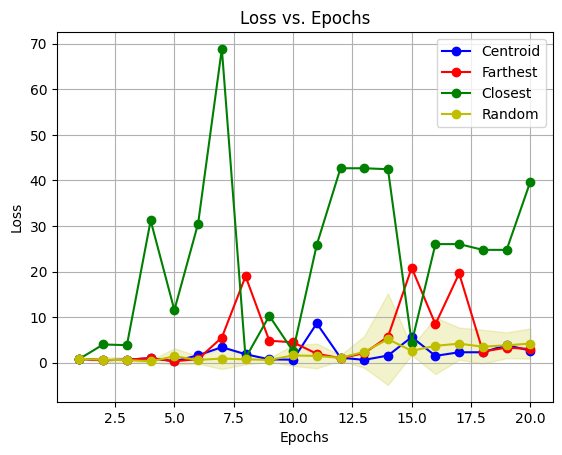

In [94]:
epochs_list = [i+1 for i in range(epochs)]
plt.plot(epochs_list, loss_list[0], marker='o', linestyle='-', color='b', label='Centroid')
plt.plot(epochs_list, loss_list[1], marker='o', linestyle='-', color='r', label = 'Farthest')
plt.plot(epochs_list, loss_list[2], marker='o', linestyle='-', color='g', label='Closest')
random_loss_mean = np.mean(random_losses, axis=0)# + 2*np.std(random_losses, axis=0)
plt.plot(epochs_list, random_loss_mean, marker='o', linestyle='-', color='y', label='Random')
plt.fill_between(epochs_list, random_loss_mean - 2*np.std(random_losses, axis=0), random_loss_mean + 2*np.std(random_losses, axis=0), alpha=0.2, color='y')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend() 
plt.grid(True)
plt.show()  

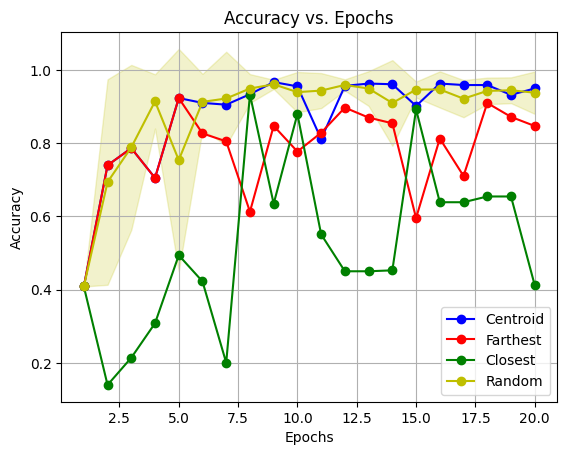

In [95]:
epochs_list = [i+1 for i in range(epochs)]
plt.plot(epochs_list, accuracy_list[0], marker='o', linestyle='-', color='b', label='Centroid')
plt.plot(epochs_list, accuracy_list[1], marker='o', linestyle='-', color='r', label = 'Farthest')
plt.plot(epochs_list, accuracy_list[2], marker='o', linestyle='-', color='g', label='Closest')
random_loss_mean = np.mean(random_accuracy, axis=0)# + 2*np.std(random_accuracy, axis=0)
plt.plot(epochs_list, random_loss_mean, marker='o', linestyle='-', color='y', label='Random')
plt.fill_between(epochs_list, random_loss_mean - 2*np.std(random_accuracy, axis=0), random_loss_mean + 2*np.std(random_accuracy, axis=0), alpha=0.2, color='y')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()  